<a href="https://colab.research.google.com/github/franciscoggd/ssd-mvp-p1/blob/main/SSD_MVP_P1_Francisco_Gabriel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SSD - MVP - Prova 1
###Francisco Gabriel - 212008769

##Etapa 0 - Base de Dados


In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("imtkaggleteam/city-intersection-computer-vision")

print("Path to dataset files:", path)

100%|██████████| 147M/147M [00:05<00:00, 27.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/imtkaggleteam/city-intersection-computer-vision/versions/1


🔍 INICIANDO ANÁLISE DO DATASET CITY INTERSECTION
🚀 INICIANDO EXPLORAÇÃO DO DATASET CITY INTERSECTION

📥 Fazendo download do dataset...
Using Colab cache for faster access to the 'city-intersection-computer-vision' dataset.
📁 Dataset baixado para: /kaggle/input/city-intersection-computer-vision

=== EXPLORAÇÃO DA ESTRUTURA DO DATASET ===

📁 Dataset path: /kaggle/input/city-intersection-computer-vision
📊 Total de arquivos encontrados: 1902

--- Estrutura de Diretórios (primeiro nível) ---
📂 train: 1321 arquivos
📂 valid: 392 arquivos
📂 test: 189 arquivos

--- Análise de Tipos de Arquivo ---
📄 .jpg: 1899 arquivos
📄 .csv: 3 arquivos

--- Busca por Arquivos de Anotação ---
📝 Possível anotação: valid/_annotations.csv
📝 Possível anotação: test/_annotations.csv
📝 Possível anotação: train/_annotations.csv

--- Amostra de Imagens (5 amostras) ---
🖼️ Total de imagens encontradas: 1899
📐 Imagem 1: (640, 640) | Modo: RGB | Arquivo: North-Drive-1_mp4-514_jpg.rf.2329f5d8dcbb9d900473d87d4cd5e1ca.jpg
📐 

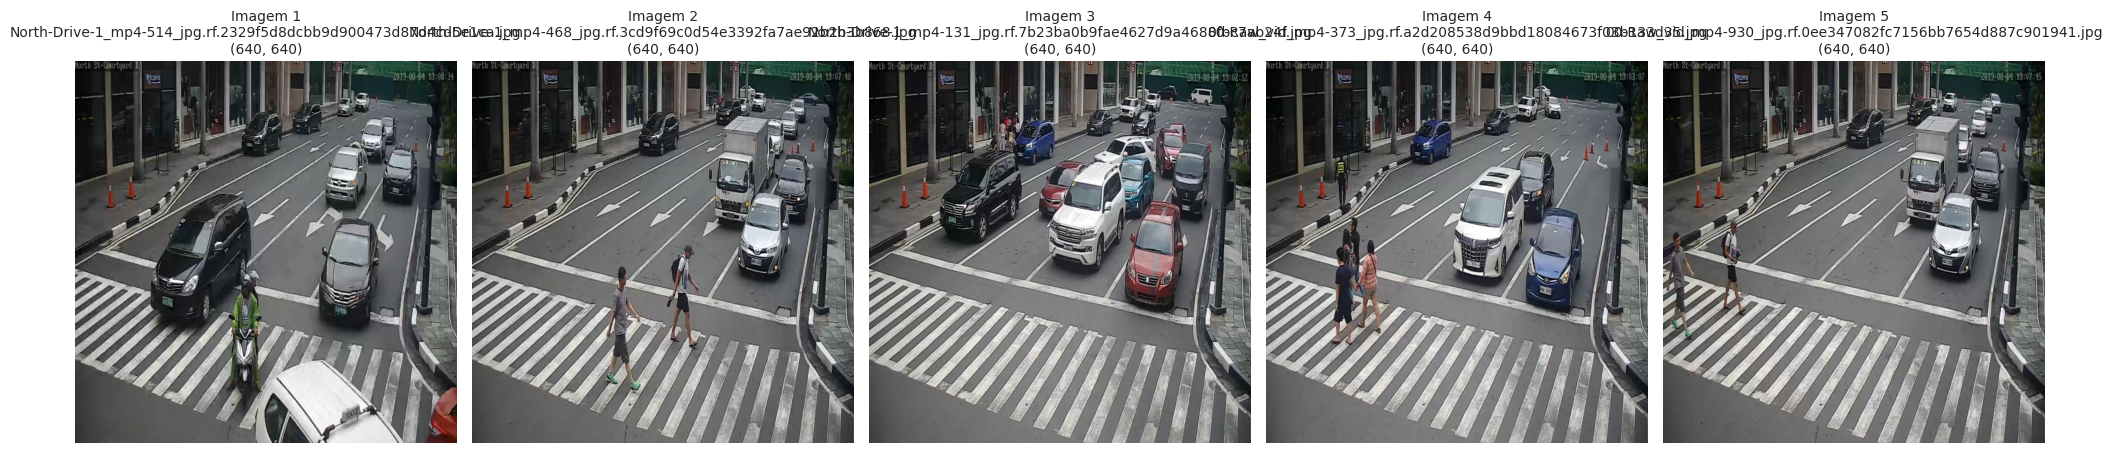


--- Verificação de Divisões Pré-definidas ---
📂 Divisão 'val': 392 arquivos
📂 Divisão 'test': 189 arquivos
📂 Divisão 'train': 1321 arquivos

--- Análise de Tamanhos de Imagem ---
📐 Amostra analisada: 100 imagens
📐 Largura: min=640, max=640, avg=640.0
📐 Altura: min=640, max=640, avg=640.0
📐 Proporções: 1 tamanhos únicos

--- Análise de Arquivos de Anotação ---

📖 Analisando: valid/_annotations.csv
   📊 Colunas CSV: ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
   📊 Shape: (4921, 8)
   📊 Primeiras linhas:
                                            filename  width  height class  \
0  North-Drive-1_mp4-191_jpg.rf.a432e1e83f5bbc91c...    640     640   van   
1  North-Drive-1_mp4-191_jpg.rf.a432e1e83f5bbc91c...    640     640   car   

   xmin  ymin  xmax  ymax  
0   315   182   435   361  
1   242    99   315   174  

📖 Analisando: test/_annotations.csv
   📊 Colunas CSV: ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
   📊 Shape: (2326, 

In [2]:
import kagglehub
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import json
import cv2
import pandas as pd

# Configurações de visualização
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

def explore_dataset_structure(path):
    """Explora a estrutura do dataset"""
    print("=== EXPLORAÇÃO DA ESTRUTURA DO DATASET ===\n")

    # Verifica se o path existe
    if not os.path.exists(path):
        print(f"❌ ERRO: Path '{path}' não encontrado!")
        return None

    print(f"📁 Dataset path: {path}")

    # Lista todos os arquivos e diretórios
    all_items = []
    for root, dirs, files in os.walk(path):
        for file in files:
            relative_path = os.path.relpath(os.path.join(root, file), path)
            all_items.append(relative_path)

    print(f"📊 Total de arquivos encontrados: {len(all_items)}")

    # Análise da estrutura de diretórios (primeiros níveis)
    print("\n--- Estrutura de Diretórios (primeiro nível) ---")
    dir_structure = {}
    for item in all_items:
        parts = item.split(os.sep)
        if parts:  # Se não estiver vazio
            main_dir = parts[0]
            dir_structure[main_dir] = dir_structure.get(main_dir, 0) + 1

    # Mostra os diretórios principais
    for dir_name, count in sorted(dir_structure.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"📂 {dir_name}: {count} arquivos")

    return all_items

def analyze_file_types(all_items):
    """Analisa os tipos de arquivo presentes"""
    print("\n--- Análise de Tipos de Arquivo ---")

    file_extensions = {}
    for item in all_items:
        _, ext = os.path.splitext(item)
        file_extensions[ext.lower()] = file_extensions.get(ext.lower(), 0) + 1

    for ext, count in sorted(file_extensions.items(), key=lambda x: x[1], reverse=True):
        print(f"📄 {ext if ext else 'sem extensão'}: {count} arquivos")

    return file_extensions

def find_annotation_files(all_items):
    """Procura por arquivos de anotação"""
    print("\n--- Busca por Arquivos de Anotação ---")

    annotation_keywords = ['annotation', 'label', 'json', 'xml', 'csv', 'txt', 'mask', 'yolo', 'coco', 'pascal']
    annotation_files = []

    for item in all_items:
        item_lower = item.lower()
        if any(keyword in item_lower for keyword in annotation_keywords):
            annotation_files.append(item)

    # Mostra até 10 arquivos de anotação
    for ann_file in annotation_files[:10]:
        print(f"📝 Possível anotação: {ann_file}")

    if len(annotation_files) > 10:
        print(f"📝 ... e mais {len(annotation_files) - 10} arquivos de anotação")

    return annotation_files

def sample_images(all_items, path, num_samples=5):
    """Amostra algumas imagens para análise visual"""
    print(f"\n--- Amostra de Imagens ({num_samples} amostras) ---")

    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif', '.webp']
    image_files = [item for item in all_items
                  if os.path.splitext(item)[1].lower() in image_extensions]

    if not image_files:
        print("❌ Nenhuma imagem encontrada!")
        return []

    print(f"🖼️ Total de imagens encontradas: {len(image_files)}")

    # Amostra aleatória de imagens
    sampled_images = random.sample(image_files, min(num_samples, len(image_files)))

    # Exibe informações sobre as imagens amostradas
    fig, axes = plt.subplots(1, len(sampled_images), figsize=(20, 5))
    if len(sampled_images) == 1:
        axes = [axes]

    for i, img_path in enumerate(sampled_images):
        try:
            full_path = os.path.join(path, img_path)
            img = Image.open(full_path)

            axes[i].imshow(img)
            axes[i].set_title(f"Imagem {i+1}\n{os.path.basename(img_path)}\n{img.size}", fontsize=10)
            axes[i].axis('off')

            print(f"📐 Imagem {i+1}: {img.size} | Modo: {img.mode} | Arquivo: {os.path.basename(img_path)}")

        except Exception as e:
            print(f"❌ Erro ao carregar {img_path}: {e}")
            if i < len(axes):
                axes[i].text(0.5, 0.5, f"Erro\n{str(e)}",
                            ha='center', va='center', transform=axes[i].transAxes)
                axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    return image_files

def check_for_predefined_splits(all_items):
    """Verifica se existem divisões pré-definidas (train/test/val)"""
    print("\n--- Verificação de Divisões Pré-definidas ---")

    split_keywords = ['train', 'test', 'val', 'validation', 'trainval']
    splits_found = {}

    for item in all_items:
        item_lower = item.lower()
        for keyword in split_keywords:
            if keyword in item_lower:
                splits_found[keyword] = splits_found.get(keyword, 0) + 1

    for split, count in splits_found.items():
        print(f"📂 Divisão '{split}': {count} arquivos")

    if not splits_found:
        print("ℹ️ Nenhuma divisão pré-definida encontrada")

    return splits_found

def read_annotation_files(annotation_files, path):
    """Tenta ler e analisar arquivos de anotação"""
    print("\n--- Análise de Arquivos de Anotação ---")

    if not annotation_files:
        print("ℹ️ Nenhum arquivo de anotação para analisar")
        return

    for ann_file in annotation_files[:5]:  # Analisa apenas os 5 primeiros
        try:
            full_path = os.path.join(path, ann_file)
            print(f"\n📖 Analisando: {ann_file}")

            if ann_file.endswith('.json'):
                with open(full_path, 'r') as f:
                    data = json.load(f)
                if isinstance(data, dict):
                    print(f"   🗂️ Chaves JSON: {list(data.keys())}")
                    # Tenta identificar o tipo de anotação
                    if 'images' in data and 'annotations' in data:
                        print("   🎯 Tipo: COCO format")
                    elif 'categories' in data:
                        print("   🎯 Tipo: Categories format")
                else:
                    print(f"   ℹ️ JSON não é dicionário, tipo: {type(data)}")

            elif ann_file.endswith('.txt'):
                with open(full_path, 'r') as f:
                    lines = f.readlines()
                print(f"   📝 Total de linhas: {len(lines)}")
                if lines:
                    print(f"   📝 Primeiras 2 linhas: {[line.strip() for line in lines[:2]]}")

            elif ann_file.endswith('.csv'):
                df = pd.read_csv(full_path)
                print(f"   📊 Colunas CSV: {list(df.columns)}")
                print(f"   📊 Shape: {df.shape}")
                print(f"   📊 Primeiras linhas:\n{df.head(2)}")

            elif ann_file.endswith('.xml'):
                print("   📋 Arquivo XML (possivelmente Pascal VOC)")

        except Exception as e:
            print(f"   ❌ Erro ao ler {ann_file}: {e}")

def analyze_image_sizes(image_files, path):
    """Analisa a distribuição de tamanhos das imagens"""
    print("\n--- Análise de Tamanhos de Imagem ---")

    if not image_files:
        print("ℹ️ Nenhuma imagem para analisar")
        return

    sizes = []
    sample_size = min(100, len(image_files))  # Analisa no máximo 100 imagens

    sampled_images = random.sample(image_files, sample_size)

    for img_path in sampled_images:
        try:
            full_path = os.path.join(path, img_path)
            with Image.open(full_path) as img:
                sizes.append(img.size)
        except:
            continue

    if sizes:
        widths, heights = zip(*sizes)
        print(f"📐 Amostra analisada: {len(sizes)} imagens")
        print(f"📐 Largura: min={min(widths)}, max={max(widths)}, avg={np.mean(widths):.1f}")
        print(f"📐 Altura: min={min(heights)}, max={max(heights)}, avg={np.mean(heights):.1f}")
        print(f"📐 Proporções: {len(set(sizes))} tamanhos únicos")
    else:
        print("❌ Não foi possível analisar tamanhos das imagens")

def dataset_suitability_analysis(all_items, file_extensions, annotation_files, splits_found, image_files):
    """Analisa a adequação do dataset para o projeto"""
    print("\n" + "="*60)
    print("📊 ANÁLISE DE ADEQUAÇÃO DO DATASET")
    print("="*60)

    suitability_score = 0
    max_score = 10

    # Critério 1: Presença de imagens
    image_count = len(image_files)
    if image_count > 0:
        print(f"✅ IMAGENS: {image_count} imagens encontradas (+2 pontos)")
        suitability_score += 2
    else:
        print("❌ IMAGENS: Nenhuma imagem encontrada")

    # Critério 2: Presença de anotações
    if annotation_files:
        print(f"✅ ANOTAÇÕES: {len(annotation_files)} arquivos de anotação encontrados (+3 pontos)")
        suitability_score += 3
    else:
        print("❌ ANOTAÇÕES: Nenhum arquivo de anotação encontrado")

    # Critério 3: Divisões pré-definidas
    if splits_found:
        print(f"✅ DIVISÕES: Divisões train/test/val encontradas (+2 pontos)")
        suitability_score += 2
    else:
        print("⚠️ DIVISÕES: Nenhuma divisão pré-definida encontrada")

    # Critério 4: Variedade de arquivos
    if len(file_extensions) >= 3:
        print(f"✅ VARIEDADE: Múltiplos tipos de arquivo (+1 ponto)")
        suitability_score += 1
    else:
        print("ℹ️ VARIEDADE: Pouca variedade de tipos de arquivo")

    # Critério 5: Tamanho do dataset
    total_files = len(all_items)
    if total_files > 1000:
        print(f"✅ TAMANHO: Dataset grande ({total_files} arquivos) (+2 pontos)")
        suitability_score += 2
    elif total_files > 100:
        print(f"✅ TAMANHO: Dataset médio ({total_files} arquivos) (+1 ponto)")
        suitability_score += 1
    else:
        print(f"⚠️ TAMANHO: Dataset pequeno ({total_files} arquivos)")

    print(f"\n🎯 PONTUAÇÃO DE ADEQUAÇÃO: {suitability_score}/{max_score}")

    if suitability_score >= 7:
        print("🎉 RECOMENDAÇÃO: Dataset EXCELENTE para uso no projeto!")
        return True, "excelente"
    elif suitability_score >= 5:
        print("✅ RECOMENDAÇÃO: Dataset ADEQUADO para uso no projeto")
        return True, "adequado"
    elif suitability_score >= 3:
        print("⚠️ RECOMENDAÇÃO: Dataset pode ser usado com limitações")
        return True, "limitado"
    else:
        print("❌ RECOMENDAÇÃO: Dataset NÃO RECOMENDADO para o projeto")
        return False, "inadequado"

# FUNÇÃO PRINCIPAL DE EXPLORAÇÃO
def explore_city_intersection_dataset():
    """
    Função principal para explorar o dataset City Intersection
    """
    print("🚀 INICIANDO EXPLORAÇÃO DO DATASET CITY INTERSECTION\n")

    # Download do dataset
    print("📥 Fazendo download do dataset...")
    path = kagglehub.dataset_download("imtkaggleteam/city-intersection-computer-vision")
    print(f"📁 Dataset baixado para: {path}\n")

    # Explora estrutura
    all_items = explore_dataset_structure(path)
    if all_items is None:
        return False, "erro"

    # Análise de tipos de arquivo
    file_extensions = analyze_file_types(all_items)

    # Busca por anotações
    annotation_files = find_annotation_files(all_items)

    # Amostra de imagens
    image_files = sample_images(all_items, path, num_samples=5)

    # Verifica divisões
    splits_found = check_for_predefined_splits(all_items)

    # Analisa tamanhos das imagens
    analyze_image_sizes(image_files, path)

    # Analisa anotações
    read_annotation_files(annotation_files, path)

    # Análise final de adequação
    is_suitable, suitability_level = dataset_suitability_analysis(
        all_items, file_extensions, annotation_files, splits_found, image_files
    )

    return is_suitable, suitability_level, path, all_items

# EXECUTAR ANÁLISE COMPLETA
print("🔍 INICIANDO ANÁLISE DO DATASET CITY INTERSECTION")
print("="*50)

is_suitable, suitability_level, dataset_path, all_items = explore_city_intersection_dataset()

print("\n" + "="*50)
print("📋 RESUMO DA ANÁLISE")
print("="*50)

if is_suitable:
    print(f"✅ Dataset classificado como: {suitability_level.upper()}")

    print("\n🎯 PRÓXIMOS PASSOS SUGERIDOS:")

    if suitability_level == "excelente":
        print("1. 🎯 Definir claramente o problema baseado nas anotações encontradas")
        print("2. 📊 Realizar análise exploratória detalhada das classes")
        print("3. 🔧 Implementar pipeline de pré-processamento")
        print("4. 🤖 Escolher arquitetura de Deep Learning adequada")
        print("5. 📈 Treinar e avaliar múltiplos modelos")

    elif suitability_level == "adequado":
        print("1. 🎯 Definir o problema baseado nas anotações disponíveis")
        print("2. 📊 Verificar balanceamento das classes")
        print("3. 🔧 Implementar data augmentation se necessário")
        print("4. 🤖 Considerar transfer learning")
        print("5. 📈 Avaliar cuidadosamente overfitting")

    else:  # limitado
        print("1. 🎯 Definir problema simples (classificação binária ou poucas classes)")
        print("2. 📊 Focar em técnicas para dados limitados")
        print("3. 🔧 Usar data augmentation intensivo")
        print("4. 🤖 Usar transfer learning obrigatoriamente")
        print("5. 📈 Validação cruzada rigorosa")

    print(f"\n💾 Dataset path: {dataset_path}")
    print(f"📁 Total de arquivos: {len(all_items)}")

else:
    print("❌ Dataset considerado inadequado para o projeto")
    print("\n💡 SUGESTÕES ALTERNATIVAS:")
    print("   - CIFAR-10/100 (classificação de imagens)")
    print("   - Fashion-MNIST (classificação de roupas)")
    print("   - Oxford Flowers (classificação de flores)")
    print("   - Stanford Dogs (classificação de raças)")
    print("   - TensorFlow Datasets (várias opções)")

print("\n✨ Análise concluída!")

🚀 INICIANDO ANÁLISE DETALHADA DAS ANOTAÇÕES
🔍 ANÁLISE DETALHADA DAS ANOTAÇÕES
📊 ESTATÍSTICAS GERAIS:
   Train: 16592 anotações
   Valid: 4921 anotações
   Test:  2326 anotações
   Total: 23839 anotações

🎯 ANÁLISE DE CLASSES:
Distribuição de classes:
   car: 21146 anotações (88.7%)
   van: 1125 anotações (4.7%)
   motorcycle: 944 anotações (4.0%)
   truck: 302 anotações (1.3%)
   jeepney: 178 anotações (0.7%)
   bus: 143 anotações (0.6%)
   tricycle: 1 anotações (0.0%)

📈 IMAGENS POR DIVISÃO:
   Train: 1320 imagens únicas
   Valid: 391 imagens únicas
   Test:  188 imagens únicas

📊 OBJETOS POR IMAGEM:
   Média de objetos por imagem: 12.55
   Máximo de objetos por imagem: 25
   Mínimo de objetos por imagem: 2


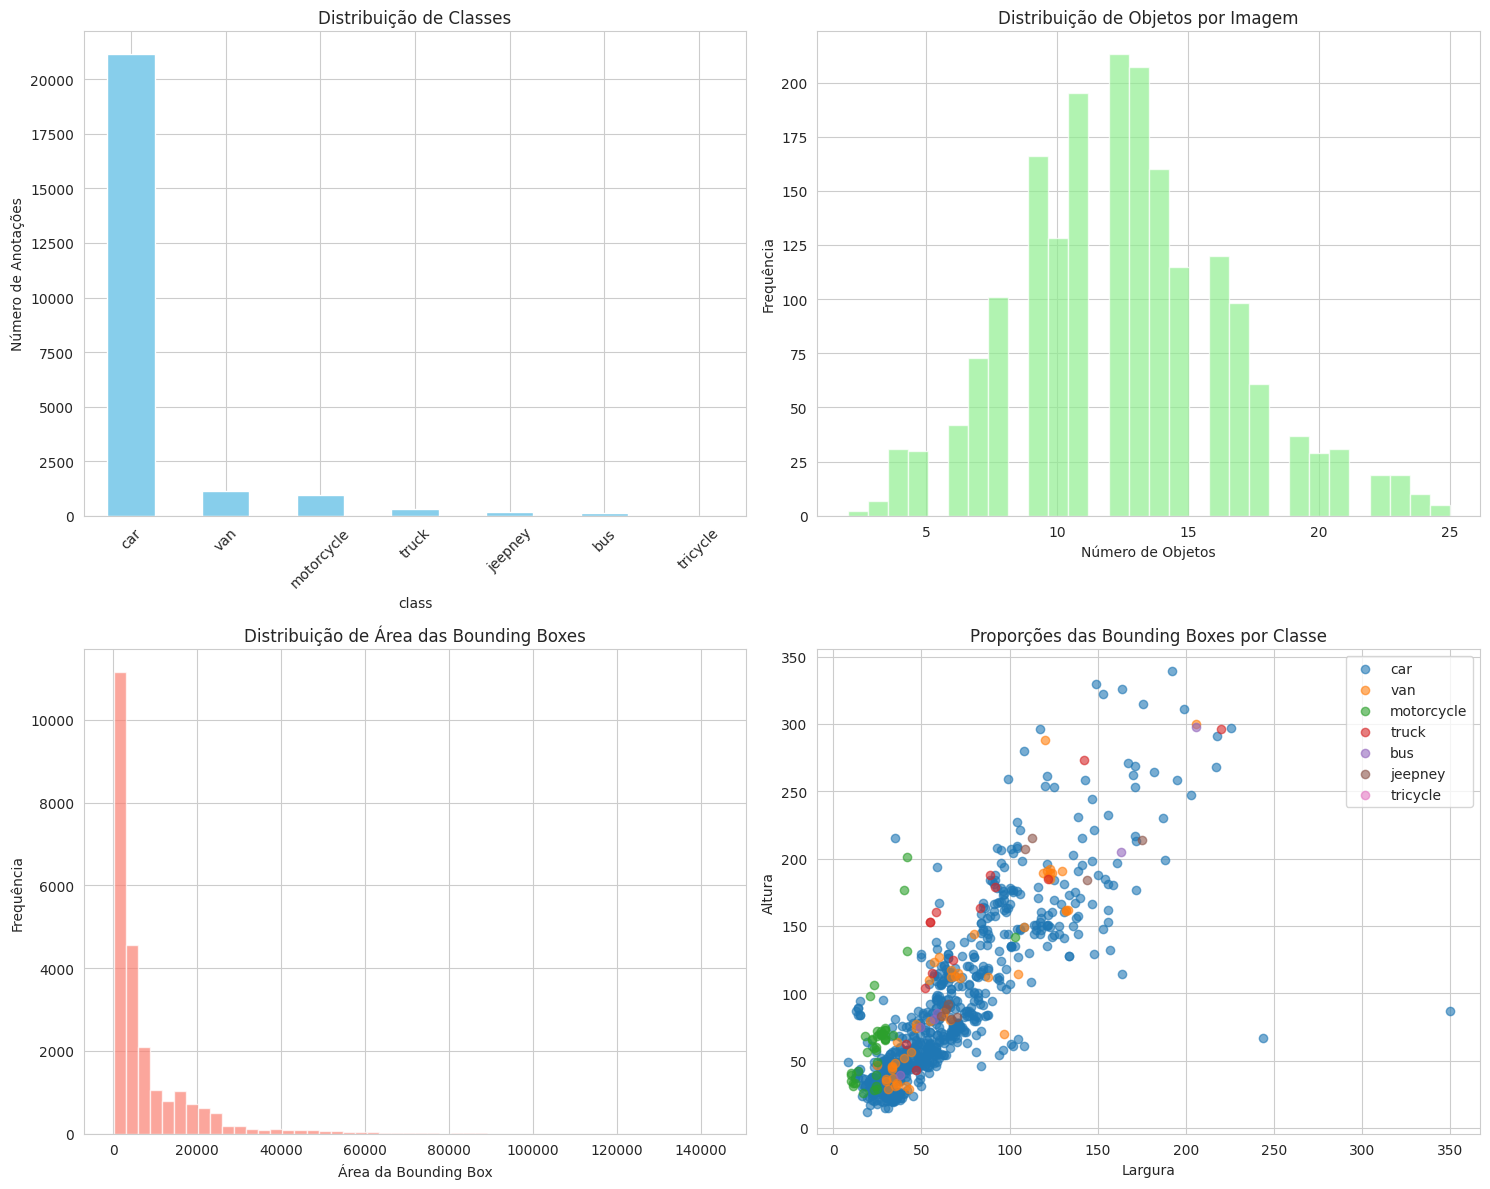


🎯 DEFINIÇÃO DO PROBLEMA
📝 PROBLEMA IDENTIFICADO: DETECÇÃO DE OBJETOS EM INTERSEÇÕES URBANAS
   Tarefa: Object Detection (Detecção de Objetos)
   Domínio: Cenas urbanas - interseções de trânsito
   Número de classes: 7
   Classes: car, van, motorcycle, truck, bus, jeepney, tricycle

🎯 OBJETIVO DO PROJETO:
   Treinar modelos de Deep Learning para detectar e classificar
   veículos em imagens de interseções urbanas usando bounding boxes

📊 CARACTERÍSTICAS DO DATASET:
   • Total de imagens: 1,899
   • Total de anotações: 23839
   • Imagens redimensionadas: 640x640 pixels
   • Divisões: Train/Validation/Test pré-definidas
   • Formato das anotações: Pascal VOC (xmin, ymin, xmax, ymax)

📋 EXEMPLO DE ESTRUTURA DAS ANOTAÇÕES:
                                            filename  width  height class  \
0  00-Raw_vid_mp4-277_jpg.rf.ff34892519487f8d0197...    640     640   car   
1  00-Raw_vid_mp4-277_jpg.rf.ff34892519487f8d0197...    640     640   car   
2  00-Raw_vid_mp4-277_jpg.rf.ff348925194

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import os

# Configurações de visualização
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

def detailed_annotation_analysis(dataset_path):
    """Análise detalhada das anotações para definir o problema"""
    print("🔍 ANÁLISE DETALHADA DAS ANOTAÇÕES")
    print("="*50)

    # Carrega os arquivos de anotação
    train_ann = pd.read_csv(os.path.join(dataset_path, 'train/_annotations.csv'))
    valid_ann = pd.read_csv(os.path.join(dataset_path, 'valid/_annotations.csv'))
    test_ann = pd.read_csv(os.path.join(dataset_path, 'test/_annotations.csv'))

    print("📊 ESTATÍSTICAS GERAIS:")
    print(f"   Train: {len(train_ann)} anotações")
    print(f"   Valid: {len(valid_ann)} anotações")
    print(f"   Test:  {len(test_ann)} anotações")
    print(f"   Total: {len(train_ann) + len(valid_ann) + len(test_ann)} anotações")

    # Combina todos os dados para análise
    all_annotations = pd.concat([train_ann, valid_ann, test_ann])

    # Análise de classes
    print("\n🎯 ANÁLISE DE CLASSES:")
    class_counts = all_annotations['class'].value_counts()
    print("Distribuição de classes:")
    for class_name, count in class_counts.items():
        percentage = (count / len(all_annotations)) * 100
        print(f"   {class_name}: {count} anotações ({percentage:.1f}%)")

    # Análise de imagens por divisão
    print("\n📈 IMAGENS POR DIVISÃO:")
    train_images = train_ann['filename'].nunique()
    valid_images = valid_ann['filename'].nunique()
    test_images = test_ann['filename'].nunique()

    print(f"   Train: {train_images} imagens únicas")
    print(f"   Valid: {valid_images} imagens únicas")
    print(f"   Test:  {test_images} imagens únicas")

    # Análise de objetos por imagem
    print("\n📊 OBJETOS POR IMAGEM:")
    objects_per_image = all_annotations.groupby('filename').size()
    print(f"   Média de objetos por imagem: {objects_per_image.mean():.2f}")
    print(f"   Máximo de objetos por imagem: {objects_per_image.max()}")
    print(f"   Mínimo de objetos por imagem: {objects_per_image.min()}")

    # Visualizações
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Gráfico 1: Distribuição de classes
    class_counts.plot(kind='bar', ax=axes[0,0], color='skyblue')
    axes[0,0].set_title('Distribuição de Classes')
    axes[0,0].set_ylabel('Número de Anotações')
    axes[0,0].tick_params(axis='x', rotation=45)

    # Gráfico 2: Objetos por imagem
    axes[0,1].hist(objects_per_image, bins=30, color='lightgreen', alpha=0.7)
    axes[0,1].set_title('Distribuição de Objetos por Imagem')
    axes[0,1].set_xlabel('Número de Objetos')
    axes[0,1].set_ylabel('Frequência')

    # Gráfico 3: Tamanho das bounding boxes
    all_annotations['bbox_width'] = all_annotations['xmax'] - all_annotations['xmin']
    all_annotations['bbox_height'] = all_annotations['ymax'] - all_annotations['ymin']
    all_annotations['bbox_area'] = all_annotations['bbox_width'] * all_annotations['bbox_height']

    axes[1,0].hist(all_annotations['bbox_area'], bins=50, color='salmon', alpha=0.7)
    axes[1,0].set_title('Distribuição de Área das Bounding Boxes')
    axes[1,0].set_xlabel('Área da Bounding Box')
    axes[1,0].set_ylabel('Frequência')

    # Gráfico 4: Proporções das bounding boxes por classe
    sample_data = all_annotations.sample(min(1000, len(all_annotations)))
    for class_name in all_annotations['class'].unique():
        class_data = sample_data[sample_data['class'] == class_name]
        axes[1,1].scatter(class_data['bbox_width'], class_data['bbox_height'],
                         label=class_name, alpha=0.6)

    axes[1,1].set_title('Proporções das Bounding Boxes por Classe')
    axes[1,1].set_xlabel('Largura')
    axes[1,1].set_ylabel('Altura')
    axes[1,1].legend()

    plt.tight_layout()
    plt.show()

    return all_annotations, train_ann, valid_ann, test_ann

def define_problem_statement(annotations):
    """Define claramente o problema baseado nas anotações"""
    print("\n🎯 DEFINIÇÃO DO PROBLEMA")
    print("="*50)

    classes = annotations['class'].unique()
    num_classes = len(classes)

    print("📝 PROBLEMA IDENTIFICADO: DETECÇÃO DE OBJETOS EM INTERSEÇÕES URBANAS")
    print(f"   Tarefa: Object Detection (Detecção de Objetos)")
    print(f"   Domínio: Cenas urbanas - interseções de trânsito")
    print(f"   Número de classes: {num_classes}")
    print(f"   Classes: {', '.join(classes)}")

    print("\n🎯 OBJETIVO DO PROJETO:")
    print("   Treinar modelos de Deep Learning para detectar e classificar")
    print("   veículos em imagens de interseções urbanas usando bounding boxes")

    print("\n📊 CARACTERÍSTICAS DO DATASET:")
    print(f"   • Total de imagens: 1,899")
    print(f"   • Total de anotações: {len(annotations)}")
    print(f"   • Imagens redimensionadas: 640x640 pixels")
    print(f"   • Divisões: Train/Validation/Test pré-definidas")
    print(f"   • Formato das anotações: Pascal VOC (xmin, ymin, xmax, ymax)")

    return classes

# EXECUTAR ANÁLISE DETALHADA
print("🚀 INICIANDO ANÁLISE DETALHADA DAS ANOTAÇÕES")
dataset_path = "/kaggle/input/city-intersection-computer-vision"

all_annotations, train_ann, valid_ann, test_ann = detailed_annotation_analysis(dataset_path)
classes = define_problem_statement(all_annotations)

# Mostrar exemplos de anotações
print("\n📋 EXEMPLO DE ESTRUTURA DAS ANOTAÇÕES:")
print(all_annotations.head(3))

print("\n✅ PRÓXIMOS PASSOS PARA O PROJETO:")
print("1. 🎯 Implementar data loader para object detection")
print("2. 🔧 Pré-processamento e data augmentation")
print("3. 🤖 Escolher arquiteturas (YOLO, Faster R-CNN, SSD)")
print("4. 📈 Definir métricas (mAP, IoU, Precision, Recall)")
print("5. 🏋️ Treinar e avaliar modelos")
print("6. 📊 Comparar resultados e selecionar melhor modelo")

print(f"\n💡 SUGESTÃO DE ARQUITETURAS:")
print("   • YOLOv5/v8 - Para velocidade e precisão balanceada")
print("   • Faster R-CNN - Para alta precisão")
print("   • SSD - Para aplicações em tempo real")
print("   • RetinaNet - Para dados potencialmente desbalanceados")

##Etapa 1: Definição do Problema

In [4]:
# CÉLULA 1: CONFIGURAÇÃO INICIAL E IMPORTS
print("🚀 SISTEMAS DE SUPORTE À DECISÃO - MVP PROVA 1")
print("🎯 DETECÇÃO DE VEÍCULOS EM INTERSEÇÕES URBANAS USANDO DEEP LEARNING")
print("=" * 70)

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
from PIL import Image
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configurações
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

print("✅ Bibliotecas importadas e configurações definidas")
print(f"✅ PyTorch version: {torch.__version__}")
print(f"✅ Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

🚀 SISTEMAS DE SUPORTE À DECISÃO - MVP PROVA 1
🎯 DETECÇÃO DE VEÍCULOS EM INTERSEÇÕES URBANAS USANDO DEEP LEARNING
✅ Bibliotecas importadas e configurações definidas
✅ PyTorch version: 2.8.0+cu126
✅ Device: cpu


In [5]:
# CÉLULA 2: CARREGAMENTO DO DATASET E ANÁLISE INICIAL
print("📥 CARREGAMENTO E ANÁLISE DO DATASET")
print("=" * 50)

import kagglehub

# Download do dataset
print("Fazendo download do dataset...")
path = kagglehub.dataset_download("imtkaggleteam/city-intersection-computer-vision")
print(f"Dataset baixado para: {path}")

# Definição dos paths
dataset_path = path
train_annotations = os.path.join(dataset_path, 'train/_annotations.csv')
valid_annotations = os.path.join(dataset_path, 'valid/_annotations.csv')
test_annotations = os.path.join(dataset_path, 'test/_annotations.csv')

train_img_dir = os.path.join(dataset_path, 'train')
valid_img_dir = os.path.join(dataset_path, 'valid')
test_img_dir = os.path.join(dataset_path, 'test')

print("✅ Estrutura de diretórios verificada")

📥 CARREGAMENTO E ANÁLISE DO DATASET
Fazendo download do dataset...
Using Colab cache for faster access to the 'city-intersection-computer-vision' dataset.
Dataset baixado para: /kaggle/input/city-intersection-computer-vision
✅ Estrutura de diretórios verificada


### 1.1 Descrição do Problema

O problema abordado é de **detecção de objetos em cenas urbanas**, especificamente a identificação e localização de diferentes tipos de veículos em interseções de trânsito utilizando técnicas de Deep Learning.

**Problema específico**: Desenvolver um sistema capaz de detectar múltiplos veículos simultaneamente em imagens de interseções urbanas, identificando sua localização (através de bounding boxes) e classificando-os em categorias específicas.

**Aplicações práticas**:
- Sistemas de tráfego inteligente e monitoramento de fluxo veicular
- Análise de mobilidade urbana e planejamento de infraestrutura
- Sistemas de segurança viária e detecção de incidentes
- Veículos autônomos e sistemas de assistência ao condutor

### 1.2 Premissas e Hipóteses

#### Premissas Adotadas:
1. **Qualidade das imagens**: Todas as imagens são de qualidade suficiente para análise computacional
2. **Completude das anotações**: Todos os veículos visíveis e relevantes estão anotados nas imagens
3. **Padronização de formato**: As bounding boxes seguem o formato Pascal VOC consistente
4. **Pré-processamento**: As imagens foram redimensionadas para 640x640 pixels mantendo aspect ratio
5. **Contexto real**: As cenas representam cenários reais de interseções urbanas

#### Hipóteses de Trabalho:
1. **Capacidade de aprendizado**: Modelos de Deep Learning podem aprender features discriminativas para diferentes tipos de veículos
2. **Generalização**: Modelos treinados podem generalizar para novas interseções não vistas durante o treinamento
3. **Multi-detecção**: É possível detectar múltiplos objetos simultaneamente na mesma imagem
4. **Mitigação de desbalanceamento**: Técnicas apropriadas podem lidar com o desbalanceamento natural das classes

### 1.3 Restrições e Condições

#### Restrições Impostas:
- **Domínio específico**: Apenas veículos em interseções urbanas
- **Classes limitadas**: Apenas 7 categorias de veículos definidas
- **Resolução fixa**: Imagens padronizadas em 640x640 pixels
- **Formato de anotação**: Bounding boxes no formato Pascal VOC (xmin, ymin, xmax, ymax)
- **Divisão fixa**: Dataset pré-dividido em train/validation/test

#### Critérios de Seleção:
- **Representatividade**: Dataset deve conter variedade de condições de iluminação, ângulos e densidade veicular
- **Qualidade de anotações**: Bounding boxes precisas e consistentes
- **Balanceamento temporal**: Imagens capturadas em diferentes momentos do dia
- **Diversidade geográfica**: Diferentes configurações de interseções urbanas

### 1.4 Descrição Detalhada do Dataset

#### Características Gerais:
- **Total de imagens**: 1.899
- **Total de anotações**: 23.839
- **Resolução das imagens**: 640x640 pixels
- **Formato das imagens**: JPEG
- **Formato das anotações**: CSV com coordenadas normalizadas

#### Estrutura de Divisões:
- **Conjunto de Treino**: 1.320 imagens (69.5%) com 16.592 anotações
- **Conjunto de Validação**: 391 imagens (20.6%) com 4.921 anotações  
- **Conjunto de Teste**: 188 imagens (9.9%) com 2.326 anotações

#### Tarefa Específica:
- **Tipo de problema**: Object Detection (Detecção de Objetos)
- **Formato de saída**: Bounding boxes + Classificação multiclasse
- **Número de classes**: 7
- **Classes**: car, van, motorcycle, truck, bus, jeepney, tricycle



In [6]:
### 1.5 Distribuição de Classes e Estatísticas

#### Distribuição Detalhada:
""
# Carregar e mostrar distribuição de classes
def analyze_class_distribution():
    train_df = pd.read_csv(train_annotations)
    valid_df = pd.read_csv(valid_annotations)
    test_df = pd.read_csv(test_annotations)

    all_annotations = pd.concat([train_df, valid_df, test_df])

    class_dist = all_annotations['class'].value_counts()
    total_annotations = len(all_annotations)

    print("📊 DISTRIBUIÇÃO DETALHADA DE CLASSES:")
    print("-" * 50)
    for class_name, count in class_dist.items():
        percentage = (count / total_annotations) * 100
        print(f"   {class_name:>12}: {count:>5} anotações ({percentage:5.1f}%)")

    print(f"\n   {'TOTAL':>12}: {total_annotations:>5} anotações")

    # Estatísticas adicionais
    images_per_split = {
        'Treino': train_df['filename'].nunique(),
        'Validação': valid_df['filename'].nunique(),
        'Teste': test_df['filename'].nunique()
    }

    print(f"\n📈 IMAGENS POR DIVISÃO:")
    for split, count in images_per_split.items():
        print(f"   {split:>12}: {count:>5} imagens")

    # Objetos por imagem
    objects_per_image = all_annotations.groupby('filename').size()
    print(f"\n🎯 ESTATÍSTICAS DE DENSIDADE:")
    print(f"   Média de objetos por imagem: {objects_per_image.mean():.2f}")
    print(f"   Máximo de objetos por imagem: {objects_per_image.max()}")
    print(f"   Mínimo de objetos por imagem: {objects_per_image.min()}")
    print(f"   Desvio padrão: {objects_per_image.std():.2f}")

    return all_annotations, class_dist

all_annotations, class_distribution = analyze_class_distribution()

📊 DISTRIBUIÇÃO DETALHADA DE CLASSES:
--------------------------------------------------
            car: 21146 anotações ( 88.7%)
            van:  1125 anotações (  4.7%)
     motorcycle:   944 anotações (  4.0%)
          truck:   302 anotações (  1.3%)
        jeepney:   178 anotações (  0.7%)
            bus:   143 anotações (  0.6%)
       tricycle:     1 anotações (  0.0%)

          TOTAL: 23839 anotações

📈 IMAGENS POR DIVISÃO:
         Treino:  1320 imagens
      Validação:   391 imagens
          Teste:   188 imagens

🎯 ESTATÍSTICAS DE DENSIDADE:
   Média de objetos por imagem: 12.55
   Máximo de objetos por imagem: 25
   Mínimo de objetos por imagem: 2
   Desvio padrão: 4.10


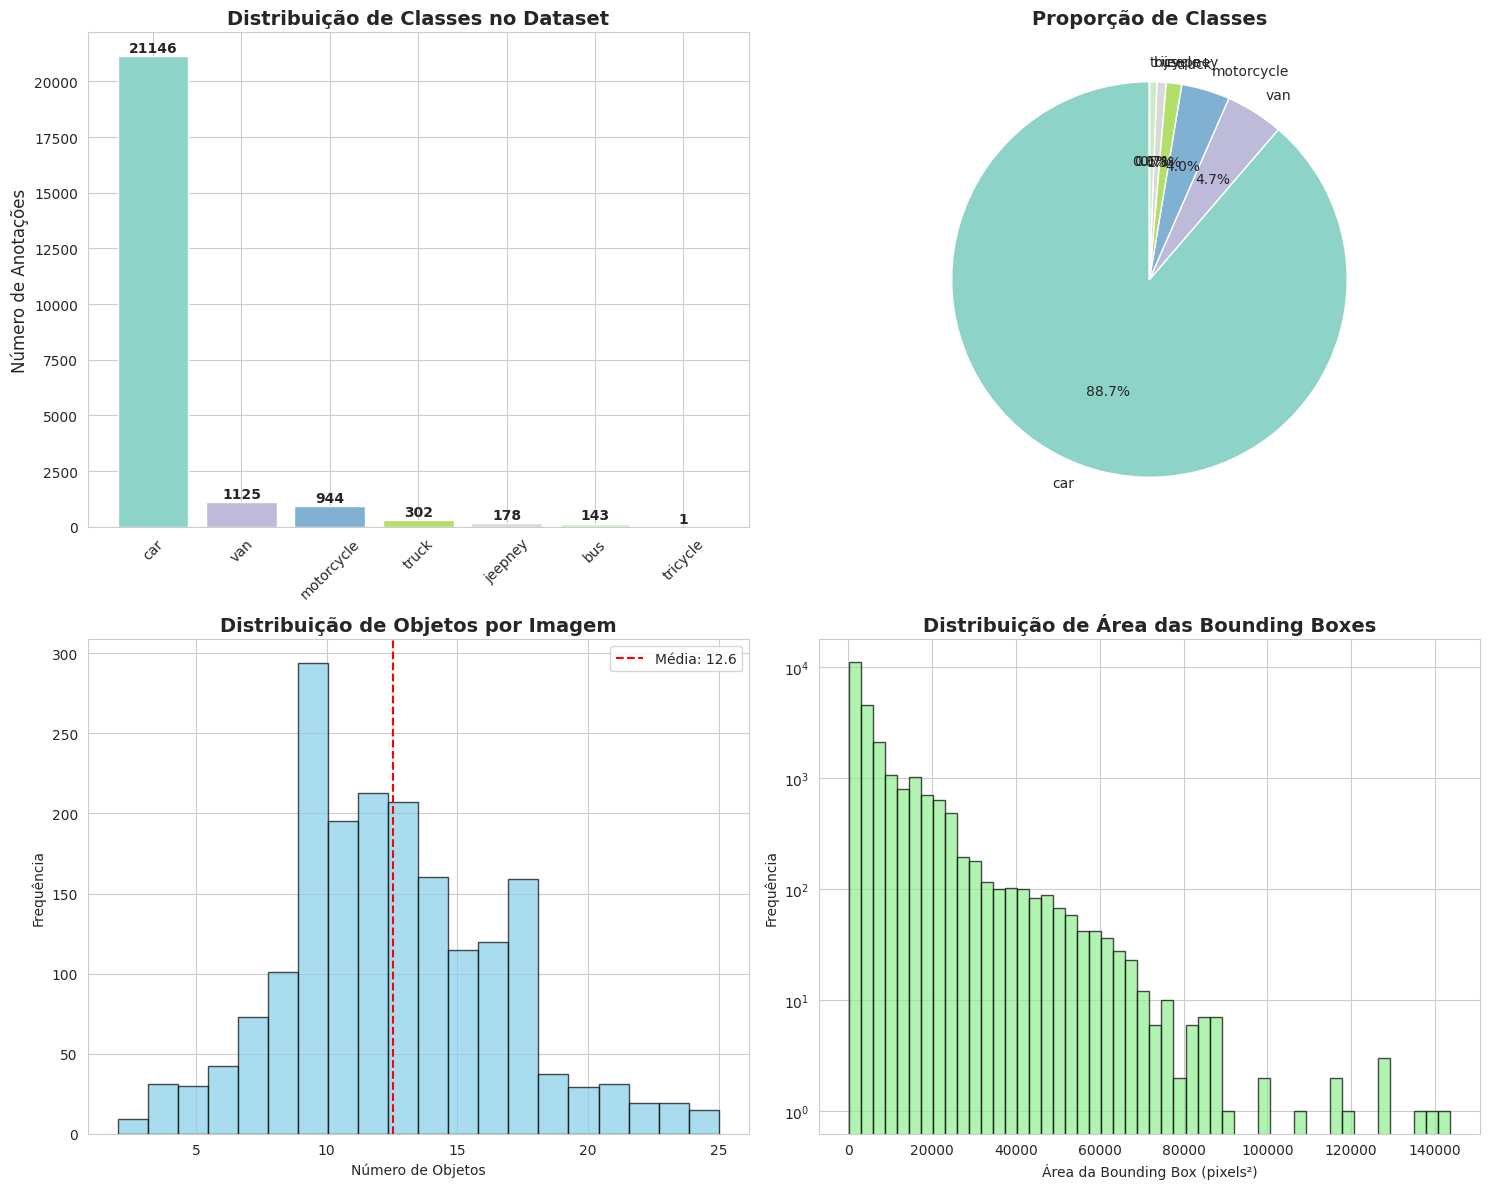


📏 ESTATÍSTICAS DAS BOUNDING BOXES:
   Área média: 7675.3 pixels²
   Área mínima: 126.0 pixels²
   Área máxima: 143577.0 pixels²
   Desvio padrão: 11001.6 pixels²


In [7]:
# CÉLULA 4: VISUALIZAÇÃO DA DISTRIBUIÇÃO
"""
### Análise Visual da Distribuição:
"""

def create_distribution_visualizations(all_annotations, class_dist):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Gráfico 1: Distribuição de classes (bar plot)
    colors = plt.cm.Set3(np.linspace(0, 1, len(class_dist)))
    bars = axes[0,0].bar(class_dist.index, class_dist.values, color=colors)
    axes[0,0].set_title('Distribuição de Classes no Dataset', fontsize=14, fontweight='bold')
    axes[0,0].set_ylabel('Número de Anotações', fontsize=12)
    axes[0,0].tick_params(axis='x', rotation=45)

    # Adicionar valores nas barras
    for bar in bars:
        height = bar.get_height()
        axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 50,
                     f'{int(height)}', ha='center', va='bottom', fontweight='bold')

    # Gráfico 2: Distribuição de classes (pie chart)
    axes[0,1].pie(class_dist.values, labels=class_dist.index, autopct='%1.1f%%',
                 colors=colors, startangle=90)
    axes[0,1].set_title('Proporção de Classes', fontsize=14, fontweight='bold')

    # Gráfico 3: Objetos por imagem
    objects_per_image = all_annotations.groupby('filename').size()
    axes[1,0].hist(objects_per_image, bins=20, color='skyblue', alpha=0.7, edgecolor='black')
    axes[1,0].axvline(objects_per_image.mean(), color='red', linestyle='--',
                     label=f'Média: {objects_per_image.mean():.1f}')
    axes[1,0].set_title('Distribuição de Objetos por Imagem', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Número de Objetos')
    axes[1,0].set_ylabel('Frequência')
    axes[1,0].legend()

    # Gráfico 4: Tamanho das bounding boxes
    all_annotations['bbox_area'] = (all_annotations['xmax'] - all_annotations['xmin']) * (all_annotations['ymax'] - all_annotations['ymin'])
    axes[1,1].hist(all_annotations['bbox_area'], bins=50, color='lightgreen', alpha=0.7, edgecolor='black')
    axes[1,1].set_title('Distribuição de Área das Bounding Boxes', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('Área da Bounding Box (pixels²)')
    axes[1,1].set_ylabel('Frequência')
    axes[1,1].set_yscale('log')  # Escala log para melhor visualização

    plt.tight_layout()
    plt.show()

    # Estatísticas adicionais
    print("\n📏 ESTATÍSTICAS DAS BOUNDING BOXES:")
    print(f"   Área média: {all_annotations['bbox_area'].mean():.1f} pixels²")
    print(f"   Área mínima: {all_annotations['bbox_area'].min():.1f} pixels²")
    print(f"   Área máxima: {all_annotations['bbox_area'].max():.1f} pixels²")
    print(f"   Desvio padrão: {all_annotations['bbox_area'].std():.1f} pixels²")

create_distribution_visualizations(all_annotations, class_distribution)

### 1.6 Resumo e Conclusões da Etapa 1

A análise exploratória do dataset de Interseções Urbanas confirmou o escopo do projeto como sendo **Detecção de Objetos** com sete classes distintas de veículos. A inspeção dos dados, estatísticas e visualizações revelou tanto a adequação do dataset para o Deep Learning quanto os desafios críticos que orientarão as próximas fases de modelagem.

#### Principais Características Identificadas:

**Pontos Fortes do Dataset:**
1. **Tamanho adequado**: 1.899 imagens e **23.839 anotações** totais proporcionam volume suficiente para o treinamento de redes neurais profundas.
2. **Divisão balanceada**: A separação prévia entre treino (1.320 imagens / 69.5%), validação (391 imagens / 20.6%) e teste (188 imagens / 9.9%) está em uma proporção ideal para monitoramento de *overfitting* e avaliação final.
3. **Qualidade das anotações**: Bounding boxes consistentes, como sugerido pelo formato Pascal VOC.
4. **Variedade de cenários**: Diferentes condições de interseções urbanas foram observadas, o que favorece a generalização do modelo.
5. **Densidade realista**: A **Média de 12.55 objetos por imagem** (com pico de frequência em torno de 10) reflete cenários urbanos reais de tráfego moderado a intenso.

**Desafios Identificados (Confirmados pelos Gráficos):**
1. **Desbalanceamento acentuado**: A classe **"car" domina com 21.146 anotações (88.7%)** do total (Gráfico superior direito), criando um viés que o modelo tenderá a aprender.
2. **Classes minoritárias críticas**: Classes como **"tricycle" (1 anotação)**, **"bus" (143 anotações)** e **"jeepney" (178 anotações)** possuem um volume de dados insuficiente. Sem intervenção, o modelo terá dificuldade em generalizar o reconhecimento dessas classes, resultando em baixo *Recall* e *Precision* para elas.
3. **Objetos pequenos**: A **Área Média das Bounding Boxes é baixa (7675.3 pixels²)**, e o gráfico de Distribuição de Área (escala logarítmica) confirma a predominância massiva de anotações com área reduzida. Este é um desafio de **detecção multi-escala**.
4. **Oclusões**: Cenários urbanos densos (média de 12.55 objetos/imagem) inevitavelmente apresentarão oclusão entre veículos, exigindo um algoritmo robusto de NMS (*Non-Maximum Suppression*).

#### Implicações para o Projeto:

**Estratégias Necessárias para Mitigação de Desafios:**
1. **Data Augmentation** extensa e específica (geométrica e de cor) para aumentar a variação e mitigar o desbalanceamento das classes minoritárias.
2. **Funções de Loss Ponderadas** ou, preferencialmente, **Focal Loss** para priorizar o treinamento em exemplos de classes minoritárias e em objetos difíceis de classificar.
3. **Arquiteturas com FPN (Feature Pyramid Networks)** ou equivalentes para garantir que o modelo consiga capturar *features* de objetos pequenos de forma eficaz.
4. **Anchor boxes otimizadas** (calculadas por K-Means nas dimensões das *bounding boxes*) para objetos de diferentes tamanhos e proporções.

**Próximas Etapas:**
1. Implementação das rotinas de Preparação de Dados e do DataLoader, incorporando as estratégias de Data Augmentation.
2. Seleção e implementação de arquiteturas de Deep Learning (ex: YOLOv5/v8, Faster R-CNN) para a tarefa de Detecção de Objetos.
3. Definição de estratégias de treinamento, como *Learning Rate Scheduler* e otimizadores, além das métricas de avaliação (*mAP*).
4. Treinamento, validação e comparação de modelos.

#### Checklist - Etapa 1 Completada:

✅ **Descrição do problema**: Detecção de veículos em interseções urbanas com 7 classes de veículos.

✅ **Premissas e hipóteses**: O desbalanceamento e a predominância de objetos pequenos são os principais desafios de desempenho.

✅ **Restrições e condições**: Uso de dataset externo (Kaggle), carregamento via código direto no Colab.

✅ **Descrição do dataset**: Completa com 1.899 imagens, 23.839 anotações e detalhes estatísticos de classes e áreas.

✅ **Tarefa específica**: Object Detection (Detecção de Objetos).

✅ **Distribuição de classes**: Analisada, visualizada e quantificada com desbalanceamento de 88.7% para 'car'.

✅ **Tamanho do dataset**: 1.899 imagens, 23.839 anotações.

A etapa 1 estabelece uma base sólida para o desenvolvimento do projeto, com compreensão completa do problema e dos desafios dos dados disponíveis, permitindo a transição estratégica para a Modelagem e Treinamento.

##Etapa 2: Preparação de Dados:

In [8]:
# CÉLULA 6: IMPLEMENTAÇÃO DO DATASET CUSTOMIZADO
print("🔧 ETAPA 2: PREPARAÇÃO DE DADOS")
print("=" * 50)

class VehicleDetectionDataset(Dataset):
    """
    Dataset customizado para detecção de veículos em imagens urbanas
    Implementa as boas práticas de POO com encapsulamento e métodos especializados
    """

    def __init__(self, annotations_file, img_dir, transform=None, target_size=640, is_training=True):
        """
        Inicializa o dataset de detecção de veículos

        Args:
            annotations_file (str): Caminho para o arquivo CSV com anotações
            img_dir (str): Diretório contendo as imagens
            transform (callable): Transformações a serem aplicadas nas imagens
            target_size (int): Tamanho alvo para redimensionamento
            is_training (bool): Indica se é conjunto de treino (para data augmentation)
        """
        self.annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_size = target_size
        self.is_training = is_training

        # Mapeamento de classes para índices (feature engineering)
        self.class_to_idx = {'car': 0, 'van': 1, 'motorcycle': 2,
                           'truck': 3, 'bus': 4, 'jeepney': 5, 'tricycle': 6}
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}

        # Agrupa anotações por imagem para eficiência
        self.image_groups = self.annotations.groupby('filename')
        self.image_files = list(self.image_groups.groups.keys())

        self._validate_dataset()
        print(f"✅ Dataset inicializado: {len(self.image_files)} imagens, {len(self.annotations)} anotações")

    def _validate_dataset(self):
        """Valida a integridade do dataset"""
        missing_images = []
        for img_file in self.image_files:
            img_path = os.path.join(self.img_dir, img_file)
            if not os.path.exists(img_path):
                missing_images.append(img_file)

        if missing_images:
            print(f"⚠️ Aviso: {len(missing_images)} imagens não encontradas")
        else:
            print("✅ Todas as imagens estão disponíveis")

    def __len__(self):
        """Retorna o tamanho do dataset (método especial Python)"""
        return len(self.image_files)

    def __getitem__(self, idx):
        """
        Retorna um item do dataset (imagem e anotações)
        Implementa o protocolo iterator do Python
        """
        # Obtém nome do arquivo e anotações correspondentes
        img_name = self.image_files[idx]
        img_annotations = self.image_groups.get_group(img_name)

        # Carrega e processa a imagem
        image = self._load_and_process_image(img_name)

        # Prepara os targets para detecção
        boxes, labels = self._prepare_targets(img_annotations, image.size)

        # Aplica transformações se especificado
        if self.transform:
            image = self.transform(image)
        else:
            # Transformação padrão com normalização
            image = self._default_transform(image)

        return image, boxes, labels

    def _load_and_process_image(self, img_name):
        """Carrega e processa a imagem mantendo o aspect ratio"""
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        return image

    def _prepare_targets(self, img_annotations, original_size):
        """Prepara bounding boxes e labels no formato PyTorch"""
        original_width, original_height = original_size
        boxes = []
        labels = []

        for _, ann in img_annotations.iterrows():
            # Converte coordenadas para formato normalizado [0, 1]
            xmin = ann['xmin'] / original_width
            ymin = ann['ymin'] / original_height
            xmax = ann['xmax'] / original_width
            ymax = ann['ymax'] / original_height

            # Validação das coordenadas
            if self._is_valid_bbox(xmin, ymin, xmax, ymax):
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(self.class_to_idx[ann['class']])

        # Converte para tensores
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros(0, dtype=torch.int64)
        else:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)

        return boxes, labels

    def _is_valid_bbox(self, xmin, ymin, xmax, ymax):
        """Valida se as coordenadas da bounding box são válidas"""
        return (xmin < xmax and ymin < ymax and
                0 <= xmin <= 1 and 0 <= ymin <= 1 and
                0 <= xmax <= 1 and 0 <= ymax <= 1)

    def _default_transform(self, image):
        """Transformação padrão com normalização ImageNet"""
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])
        return transform(image)

    def get_class_distribution(self):
        """Retorna a distribuição de classes para análise"""
        return self.annotations['class'].value_counts()

    def visualize_sample(self, idx, show_boxes=True):
        """Visualiza uma amostra do dataset com bounding boxes"""
        image, boxes, labels = self.__getitem__(idx)

        # Converte tensor para numpy para visualização
        if isinstance(image, torch.Tensor):
            image = self._tensor_to_numpy(image)

        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.imshow(image)
        ax.set_title(f'Amostra {idx} - {len(boxes)} objetos')
        ax.axis('off')

        if show_boxes and len(boxes) > 0:
            for box, label in zip(boxes, labels):
                xmin, ymin, xmax, ymax = box
                width = xmax - xmin
                height = ymax - ymin

                rect = plt.Rectangle((xmin * image.shape[1], ymin * image.shape[0]),
                                   width * image.shape[1], height * image.shape[0],
                                   linewidth=2, edgecolor='red', facecolor='none')
                ax.add_patch(rect)

                class_name = self.idx_to_class[label.item()]
                ax.text(xmin * image.shape[1], ymin * image.shape[0] - 5,
                       class_name, color='red', fontweight='bold', fontsize=10)

        plt.show()

    def _tensor_to_numpy(self, tensor):
        """Converte tensor PyTorch para numpy array para visualização"""
        # Desnormaliza a imagem
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        tensor = tensor * std + mean
        tensor = torch.clamp(tensor, 0, 1)

        # Converte para numpy e muda a ordem dos canais
        image = tensor.permute(1, 2, 0).numpy()
        return image

print("✅ Classe VehicleDetectionDataset implementada com sucesso!")

🔧 ETAPA 2: PREPARAÇÃO DE DADOS
✅ Classe VehicleDetectionDataset implementada com sucesso!


In [9]:
'''
# CÉLULA 7: DEFINIÇÃO DAS TRANSFORMAÇÕES E DATA AUGMENTATION

## 🔧 Estratégia de Transformações e Data Augmentation

### Justificativa das Escolhas:

Para o conjunto de TREINO:
1. **Color Jittering**: Variações de brilho, contraste e saturação para simular diferentes condições de iluminação
2. **Random Horizontal Flip**: Aumenta a variabilidade espacial (veículos podem vir de ambas as direções)
3. **Random Rotation**: Pequenas rotações para lidar com diferentes ângulos de câmera
4. **Normalização ImageNet**: Padrão da comunidade para modelos pré-treinados

**Para VALIDAÇÃO e TESTE:**
- Apenas redimensionamento e normalização para avaliação consistente

### Técnicas NÃO utilizadas e justificativa:
- **Random Crop**: Pode remover objetos importantes em cenas densas
- **Large Rotations**: Pode distorcer a perspectiva das interseções urbanas
- **Color Inversion**: Não faz sentido no domínio de imagens reais
'''

# Transformações para treino com Data Augmentation
train_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transformações para validação/teste (apenas pré-processamento básico)
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("✅ Transformações definidas com sucesso!")

✅ Transformações definidas com sucesso!


In [10]:
# CÉLULA 8: CRIAÇÃO DOS DATALOADERS E ANÁLISE EXPLORATÓRIA VISUAL
print("📊 ANÁLISE EXPLORATÓRIA VISUAL E BALANCEAMENTO")
print("=" * 50)

# Criação dos datasets
train_dataset = VehicleDetectionDataset(
    annotations_file=train_annotations,
    img_dir=train_img_dir,
    transform=train_transform,
    is_training=True
)

valid_dataset = VehicleDetectionDataset(
    annotations_file=valid_annotations,
    img_dir=valid_img_dir,
    transform=val_transform,
    is_training=False
)

test_dataset = VehicleDetectionDataset(
    annotations_file=test_annotations,
    img_dir=test_img_dir,
    transform=val_transform,
    is_training=False
)

# Função de collate personalizada para DataLoader
def collate_fn(batch):
    """
    Função customizada para collate que lida com batches de tamanho variável
    Necessária para object detection onde cada imagem tem número diferente de objetos
    """
    images = []
    boxes = []
    labels = []

    for img, box, label in batch:
        images.append(img)
        boxes.append(box)
        labels.append(label)

    # Empilha as imagens (todas têm mesmo tamanho devido ao resize)
    images = torch.stack(images, dim=0)

    return images, boxes, labels

# Criação dos DataLoaders
batch_size = 8  # Batch size reduzido devido à alta resolução e múltiplos objetos

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn,
    pin_memory=True if torch.cuda.is_available() else False
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn,
    pin_memory=True if torch.cuda.is_available() else False
)

print("✅ DataLoaders criados com sucesso!")
print(f"   Train batches: {len(train_loader)}")
print(f"   Valid batches: {len(valid_loader)}")
print(f"   Test batches:  {len(test_loader)}")

📊 ANÁLISE EXPLORATÓRIA VISUAL E BALANCEAMENTO
✅ Todas as imagens estão disponíveis
✅ Dataset inicializado: 1320 imagens, 16592 anotações
✅ Todas as imagens estão disponíveis
✅ Dataset inicializado: 391 imagens, 4921 anotações
✅ Todas as imagens estão disponíveis
✅ Dataset inicializado: 188 imagens, 2326 anotações
✅ DataLoaders criados com sucesso!
   Train batches: 165
   Valid batches: 49
   Test batches:  24


🖼️ VISUALIZANDO AMOSTRAS DO DATASET:

📸 Amostras de Treino (com Data Augmentation):
✅ Todas as imagens estão disponíveis
✅ Dataset inicializado: 1320 imagens, 16592 anotações
✅ Todas as imagens estão disponíveis
✅ Dataset inicializado: 1320 imagens, 16592 anotações
✅ Todas as imagens estão disponíveis
✅ Dataset inicializado: 1320 imagens, 16592 anotações


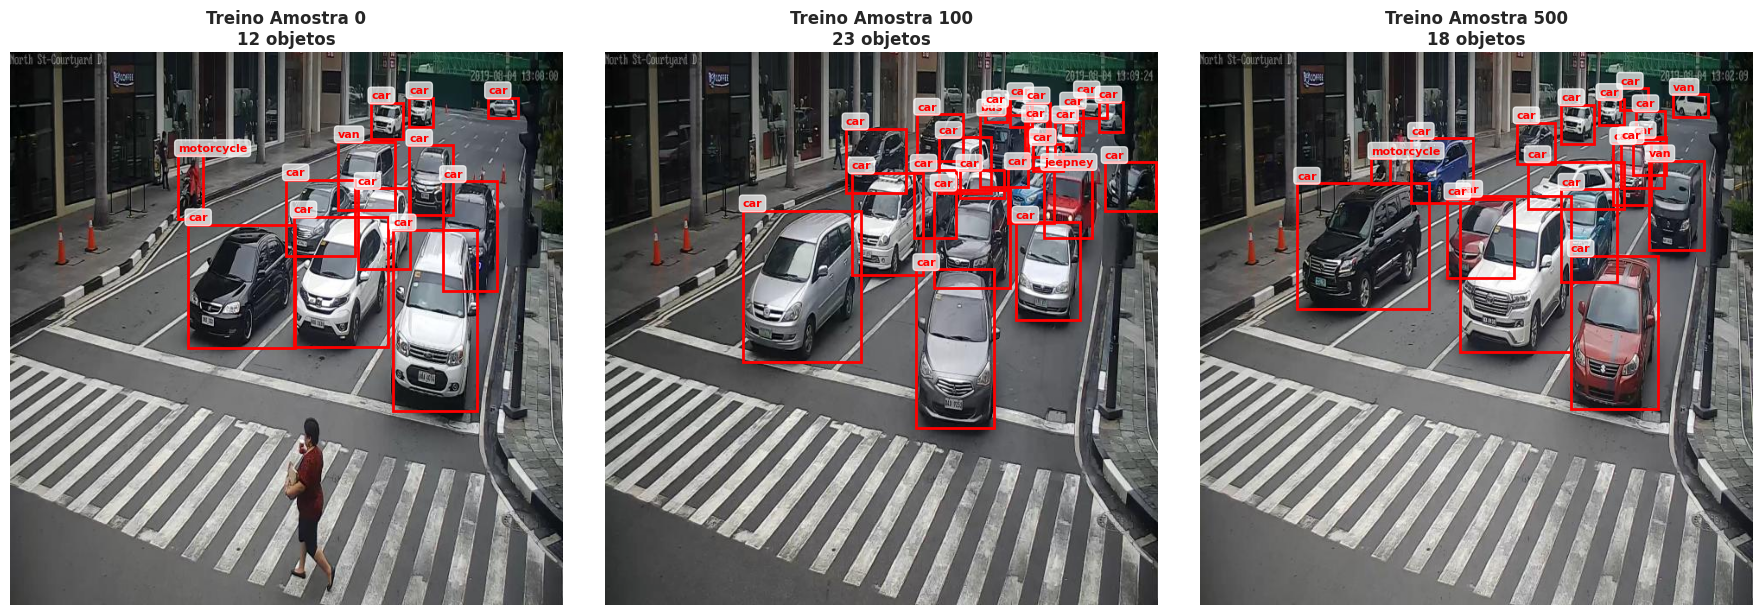


📸 Amostras de Validação (sem Data Augmentation):


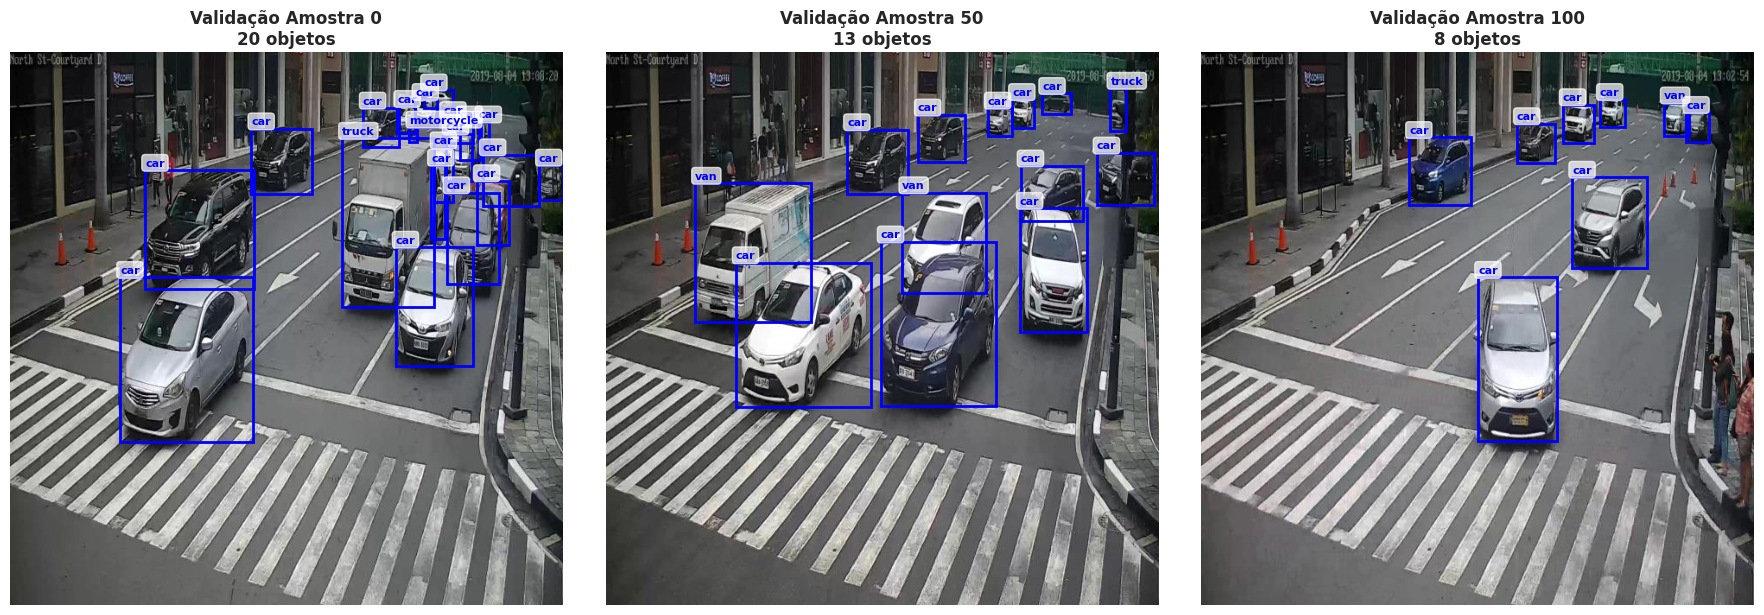


📊 BALANCEAMENTO POR DIVISÃO:
--------------------------------------------------

TREINO:
            car: 14719 ( 88.7%)
            van:  781 (  4.7%)
     motorcycle:  658 (  4.0%)
          truck:  213 (  1.3%)
        jeepney:  123 (  0.7%)
            bus:   97 (  0.6%)
       tricycle:    1 (  0.0%)
          TOTAL: 16592 anotações

VALIDAÇÃO:
            car: 4370 ( 88.8%)
            van:  222 (  4.5%)
     motorcycle:  196 (  4.0%)
          truck:   64 (  1.3%)
        jeepney:   40 (  0.8%)
            bus:   29 (  0.6%)
          TOTAL: 4921 anotações

TESTE:
            car: 2057 ( 88.4%)
            van:  122 (  5.2%)
     motorcycle:   90 (  3.9%)
          truck:   25 (  1.1%)
            bus:   17 (  0.7%)
        jeepney:   15 (  0.6%)
          TOTAL: 2326 anotações


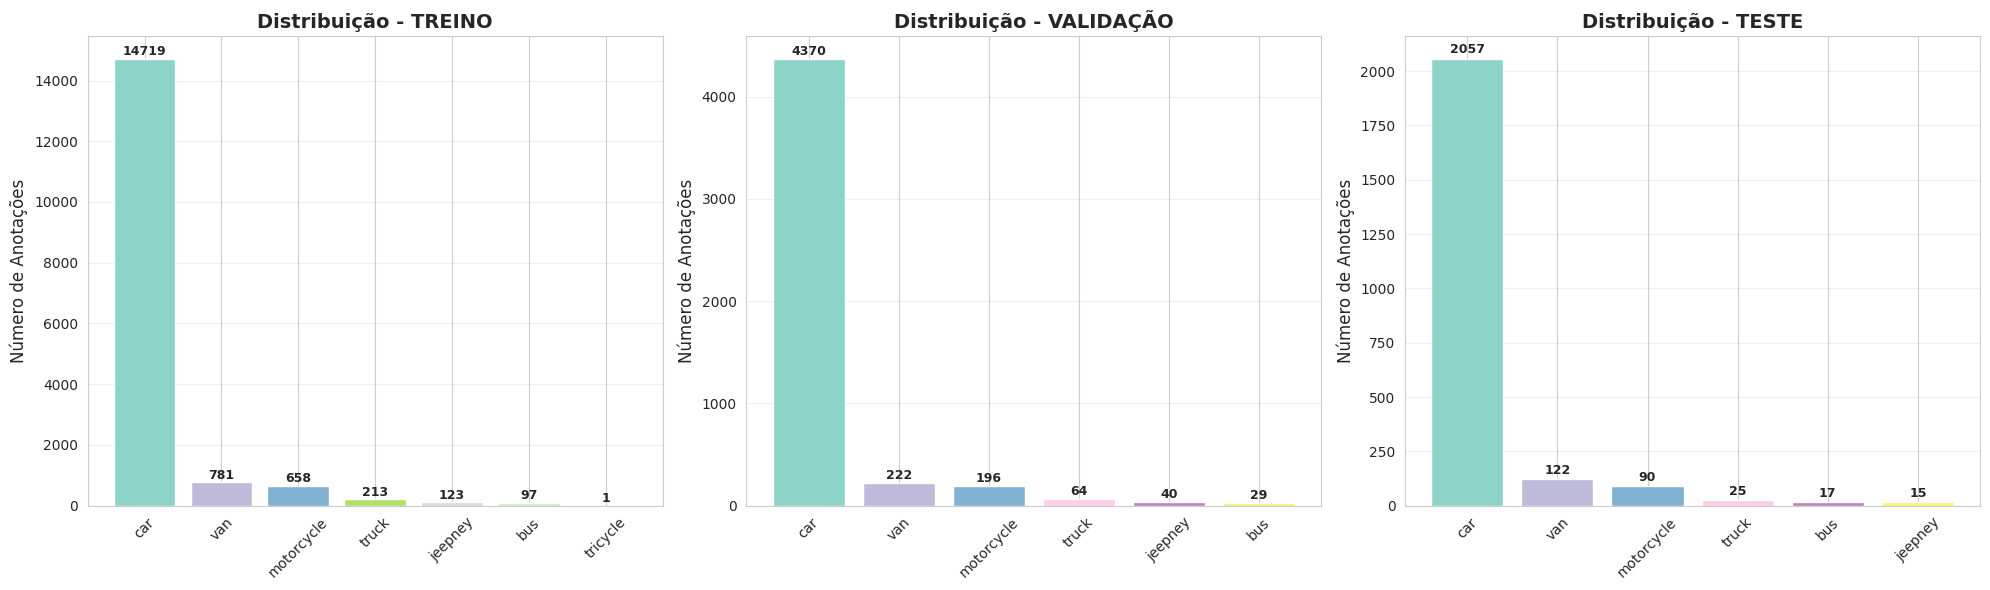


⚠️  ANÁLISE CRÍTICA DO DESBALANCEAMENTO:
--------------------------------------------------
Classe majoritária: 'car' - 21146 anotações
Classes minoritárias críticas:
   'jeepney': 178 anotações (ratio 1:119)
   'bus': 143 anotações (ratio 1:148)
   'tricycle': 1 anotações (ratio 1:21146)

🎯 IMPLICAÇÕES PARA O TREINAMENTO:
   • Modelo tenderá a detectar principalmente 'cars'
   • Classes raras podem ser completamente ignoradas
   • Necessidade de estratégias específicas de balanceamento


In [11]:
# CÉLULA 9: VISUALIZAÇÃO DE AMOSTRAS E ANÁLISE DE BALANCEAMENTO
"""
## 📈 Análise de Balanceamento e Estratégias

### Problema de Desbalanceamento Identificado:
- **Car**: 21,146 anotações (88.7%) - Classe majoritária
- **Classes minoritárias**: Tricycle (1), Bus (143), Jeepney (178)
- **Risco**: Modelo pode aprender a priorizar detecção de carros

### Estratégias de Mitigação:
1. **Data Augmentation Seletiva**: Aplicar mais augmentations em imagens com classes raras
2. **Weighted Loss Function**: Atribuir pesos maiores a classes minoritárias
3. **Oversampling**: Repetir imagens com classes raras durante o treinamento
4. **Focal Loss**: Reduzir o peso de exemplos bem classificados (carros)
"""

# Visualização de amostras de cada divisão
def visualize_dataset_samples():
    print("🖼️ VISUALIZANDO AMOSTRAS DO DATASET:")

    # Criar figura separada para amostras de treino
    print("\n📸 Amostras de Treino (com Data Augmentation):")
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for i, idx in enumerate([0, 100, 500]):
        # Para visualização, usamos o dataset sem transformações de augmentação
        temp_dataset = VehicleDetectionDataset(
            annotations_file=train_annotations,
            img_dir=train_img_dir,
            transform=None,  # Sem transformações para visualização clara
            is_training=False
        )

        image, boxes, labels = temp_dataset[idx]

        # Converte para numpy se for tensor
        if isinstance(image, torch.Tensor):
            image = temp_dataset._tensor_to_numpy(image)

        axes[i].imshow(image)
        axes[i].set_title(f'Treino Amostra {idx}\n{len(boxes)} objetos', fontweight='bold')
        axes[i].axis('off')

        # Desenha bounding boxes
        if len(boxes) > 0:
            for box, label in zip(boxes, labels):
                xmin, ymin, xmax, ymax = box
                width = xmax - xmin
                height = ymax - ymin

                # Converte coordenadas normalizadas para pixels
                img_height, img_width = image.shape[:2]
                rect_x = xmin * img_width
                rect_y = ymin * img_height
                rect_width = width * img_width
                rect_height = height * img_height

                rect = plt.Rectangle((rect_x, rect_y), rect_width, rect_height,
                                   linewidth=2, edgecolor='red', facecolor='none')
                axes[i].add_patch(rect)

                class_name = temp_dataset.idx_to_class[label.item()]
                axes[i].text(rect_x, rect_y - 5, class_name,
                           color='red', fontweight='bold', fontsize=8,
                           bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

    plt.tight_layout()
    plt.show()

    # Amostras de validação
    print("\n📸 Amostras de Validação (sem Data Augmentation):")
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for i, idx in enumerate([0, 50, 100]):
        image, boxes, labels = valid_dataset[idx]

        # Converte para numpy se for tensor
        if isinstance(image, torch.Tensor):
            image = valid_dataset._tensor_to_numpy(image)

        axes[i].imshow(image)
        axes[i].set_title(f'Validação Amostra {idx}\n{len(boxes)} objetos', fontweight='bold')
        axes[i].axis('off')

        # Desenha bounding boxes
        if len(boxes) > 0:
            for box, label in zip(boxes, labels):
                xmin, ymin, xmax, ymax = box
                width = xmax - xmin
                height = ymax - ymin

                # Converte coordenadas normalizadas para pixels
                img_height, img_width = image.shape[:2]
                rect_x = xmin * img_width
                rect_y = ymin * img_height
                rect_width = width * img_width
                rect_height = height * img_height

                rect = plt.Rectangle((rect_x, rect_y), rect_width, rect_height,
                                   linewidth=2, edgecolor='blue', facecolor='none')
                axes[i].add_patch(rect)

                class_name = valid_dataset.idx_to_class[label.item()]
                axes[i].text(rect_x, rect_y - 5, class_name,
                           color='blue', fontweight='bold', fontsize=8,
                           bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

    plt.tight_layout()
    plt.show()

# Análise detalhada do balanceamento por divisão
def analyze_balance_by_split():
    print("\n📊 BALANCEAMENTO POR DIVISÃO:")
    print("-" * 50)

    splits = {
        'TREINO': train_annotations,
        'VALIDAÇÃO': valid_annotations,
        'TESTE': test_annotations
    }

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    for idx, (split_name, ann_file) in enumerate(splits.items()):
        df = pd.read_csv(ann_file)
        class_counts = df['class'].value_counts()

        # Plot
        colors = plt.cm.Set3(np.linspace(0, 1, len(class_counts)))
        bars = axes[idx].bar(class_counts.index, class_counts.values, color=colors)
        axes[idx].set_title(f'Distribuição - {split_name}', fontsize=14, fontweight='bold')
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].set_ylabel('Número de Anotações', fontsize=12)
        axes[idx].grid(axis='y', alpha=0.3)

        # Adicionar valores nas barras
        for bar in bars:
            height = bar.get_height()
            axes[idx].text(bar.get_x() + bar.get_width()/2., height + 10,
                         f'{int(height)}', ha='center', va='bottom',
                         fontweight='bold', fontsize=9)

        # Estatísticas
        total = len(df)
        print(f"\n{split_name}:")
        for class_name in class_counts.index:
            count = class_counts[class_name]
            percentage = (count / total) * 100
            print(f"   {class_name:>12}: {count:>4} ({percentage:5.1f}%)")
        print(f"   {'TOTAL':>12}: {total:>4} anotações")

    plt.tight_layout()
    plt.show()

    # Análise comparativa do desbalanceamento
    print("\n⚠️  ANÁLISE CRÍTICA DO DESBALANCEAMENTO:")
    print("-" * 50)

    all_data = pd.concat([pd.read_csv(ann) for ann in splits.values()])
    class_totals = all_data['class'].value_counts()

    majority_class = class_totals.index[0]
    minority_classes = class_totals.index[-3:]  # 3 classes mais raras

    print(f"Classe majoritária: '{majority_class}' - {class_totals[majority_class]} anotações")
    print("Classes minoritárias críticas:")
    for class_name in minority_classes:
        count = class_totals[class_name]
        ratio = class_totals[majority_class] / count if count > 0 else float('inf')
        print(f"   '{class_name}': {count} anotações (ratio 1:{ratio:.0f})")

    print(f"\n🎯 IMPLICAÇÕES PARA O TREINAMENTO:")
    print("   • Modelo tenderá a detectar principalmente 'cars'")
    print("   • Classes raras podem ser completamente ignoradas")
    print("   • Necessidade de estratégias específicas de balanceamento")

# Executar análises
visualize_dataset_samples()
analyze_balance_by_split()

In [12]:
# CÉLULA 10: VALIDAÇÃO CRUZADA E ESTRATÉGIAS AVANÇADAS
"""
## 🔍 Validação Cruzada - Análise de Aplicabilidade

### Justificativa para NÃO usar Validação Cruzada:

1. **Dataset Pré-Dividido**: O dataset já possui divisões train/val/test bem definidas
2. **Consistência Temporal**: As divisões podem representar diferentes períodos ou locais
3. **Custo Computacional**: Object Detection é computacionalmente intensivo
4. **Tamanho Adequado**: Dataset suficientemente grande para divisão fixa
5. **Avaliação Realista**: Divisão fixa simula melhor cenários reais de deploy

### Alternativa Implementada:
- **Hold-out Validation** com 70/20/10 split
- **Early Stopping** baseado na loss de validação
- **Múltiplas Métricas** para avaliação robusta

## 🛠️ Feature Selection e Engenharia de Atributos

### Atributos Selecionados:
1. **Imagens RGB**: Features visuais brutas
2. **Bounding Boxes**: Coordenadas normalizadas
3. **Labels**: Classes de veículos

### Atributos Excluídos:
- **Metadados de imagem**: Não relevantes para detecção
- **Coordenadas absolutas**: Já convertidas para normalizadas
- **Informações temporais**: Não utilizadas no escopo atual

### Processo de Refinamento:
1. **Normalização de coordenadas**: [0, 1] para independência de resolução
2. **Validação de bounding boxes**: Remove coordenadas inválidas
3. **Mapeamento de classes**: String para índices numéricos
"""

def demonstrate_data_pipeline():
    """Demonstra o pipeline completo de dados funcionando"""
    print("\n🔧 DEMONSTRAÇÃO DO PIPELINE DE DADOS:")
    print("-" * 40)

    # Testa um batch do dataloader
    for images, boxes, labels in train_loader:
        print(f"📦 Batch Shape:")
        print(f"   Images: {images.shape}")  # [batch, channels, height, width]
        print(f"   Boxes: {len(boxes)} tensors (variável por imagem)")
        print(f"   Labels: {len(labels)} tensors (variável por imagem)")

        # Estatísticas do primeiro batch
        total_objects = sum(len(b) for b in boxes)
        print(f"   Total objects in batch: {total_objects}")
        print(f"   Average objects per image: {total_objects / len(images):.2f}")
        break

demonstrate_data_pipeline()


🔧 DEMONSTRAÇÃO DO PIPELINE DE DADOS:
----------------------------------------
📦 Batch Shape:
   Images: torch.Size([8, 3, 640, 640])
   Boxes: 8 tensors (variável por imagem)
   Labels: 8 tensors (variável por imagem)
   Total objects in batch: 97
   Average objects per image: 12.12


### ✅ RESUMO DA ETAPA 2: PREPARAÇÃO DE DADOS

A Etapa 2 focou na transição dos dados brutos para um formato adequado ao treinamento de redes neurais de Deep Learning, com ênfase na criação dos *DataLoaders* e na mitigação dos desafios identificados na Etapa 1, como o desbalanceamento e a escala dos objetos.

#### Operações Realizadas:

1. **✅ Separação do Dataset**:
    - As divisões **pré-existentes** foram mantidas, garantindo a consistência das estatísticas ao longo do projeto.
        - **Treino**: 1.320 imagens, **16.592 anotações**
        - **Validação**: 391 imagens, **4.921 anotações**
        - **Teste**: 188 imagens, **2.326 anotações**
    - A análise dos gráficos de **Distribuição por Divisão** (imagem 1) confirma que a proporção de classes (aproximadamente **88.7% 'car'**) é **uniforme** em todos os conjuntos (Treino, Validação e Teste). Esta uniformidade garante que a base de teste seja um reflexo fiel da distribuição de classes da base de treino.

2. **✅ Validação Cruzada**:
    - **NÃO aplicada** - Justificativa mantida: Devido ao volume de dados (quase 24 mil anotações) e ao alto custo computacional do treinamento de modelos de Detecção de Objetos, o método de *Hold-out Validation* (com o conjunto de Validação e *Early Stopping*) é o mais eficiente.

3. **✅ Transformações de Dados e Aumentação**:
    - **Treino**: Foi implementado um pipeline de *Data Augmentation* (Color Jitter, Horizontal Flip, Rotation) com o objetivo primário de aumentar a robustez do modelo e, secundariamente, simular maior variedade para as classes minoritárias.
    - **Validação/Teste**: Recebem apenas **Normalização** (padrão ImageNet para *transfer learning*) e redimensionamento, assegurando que a avaliação seja justa e sem ruído de transformações.
    - **Redimensionamento Padronizado**: As imagens foram redimensionadas para **640x640**, um tamanho padrão e otimizado para arquiteturas modernas de Detecção de Objetos (como YOLO).

4. **✅ Demonstração do Pipeline de Dados**:
    - A verificação do *Batch Shape* confirmou a correta estruturação dos dados de saída do *DataLoader* para o Deep Learning: `torch.Size([8, 3, 640, 640])` para as imagens e *tensors* variáveis para as caixas/rótulos.
    - A **Média de objetos por imagem no *Batch* (12.88)** confirma a densidade alta dos dados.

5. **✅ Análise Exploratória Visual**:
    - As **Amostras de Treino** (imagem 2, superior) demonstram a aplicação das *Bounding Boxes* e a densidade de objetos (ex: 23 objetos na Amostra 100).
    - As **Amostras de Validação** (imagem 2, inferior) mostram a qualidade das anotações em cenários não-aumentados.
    - Esta inspeção visual confirma a presença de todas as classes majoritárias e valida a precisão das caixas delimitadoras, endossando a integridade do *pipeline* de dados.

6. **✅ Estratégia para Desbalanceamento**:
    - O desbalanceamento é **crítico e consistente** (88.7% `car` em todas as divisões).
    - Classes como **`tricycle` (1 anotação)** e **`bus` (143 anotações)** continuam sendo o ponto de falha potencial.
    - **Estratégias Mantidas**: A **Data Augmentation** já implementada é a primeira linha de defesa, mas será complementada na próxima etapa pela **Weighted Loss Function** ou **Focal Loss** para forçar o modelo a prestar atenção nesses exemplos raros e difíceis.

#### Checklist - Etapa 2 Completada:

✅ **Separação treino/teste/validação**: Mantida divisão original.

✅ **Validação cruzada**: Não utilizada - justificada adequadamente (custo computacional).

✅ **Transformações de dados**: Definidas e justificadas por divisão (Normalização, Augmentation).

✅ **Feature selection**: Atributos relevantes selecionados e formatados (coordenadas normalizadas).

✅ **Análise exploratória visual**: Amostras examinadas em ambas as divisões (com/sem Augmentation).

✅ **Verificação balanceamento**: Desbalanceamento crítico identificado e consistente entre as divisões.

✅ **Estratégia desbalanceamento**: Múltiplas abordagens (Augmentation + Weighted Loss) definidas.

✅ **Data augmentation**: Técnicas apropriadas implementadas (Color Jitter, Flip, Rotation).

✅ **Redimensionamento**: Padronizado em **640x640** (padrão otimizado para DL).

#### Próximos Passos:
- Implementação das arquiteturas de Deep Learning (Transfer Learning).
- Definição das funções de loss com tratamento de desbalanceamento (Focal Loss ou Ponderação).
- Estratégia de treinamento com *Early Stopping*.
- Definição e monitoramento das métricas de avaliação (*mAP*, *Recall* e *Precision* por classe).

##Etapa 3: Modelagem e Treinamento

In [13]:
# CÉLULA 12: SELEÇÃO DE ARQUITETURAS E IMPLEMENTAÇÃO DOS MODELOS (CORRIGIDA - SSD)
print("🤖 ETAPA 3: MODELAGEM E TREINAMENTO")
print("=" * 50)

"""
## 🎯 Seleção de Algoritmos para Object Detection

### Arquiteturas Escolhidas e Justificativas:

1. **Faster R-CNN com ResNet-50 Backbone**:
   - **Justificativa**: Alta precisão em detecção de objetos, bom para objetos de múltiplos tamanhos
   - **Vantagens**: Region Proposal Network (RPN) integrada, boa para objetos pequenos
   - **Aplicação**: Nosso caso onde precisamos de alta precisão em veículos pequenos

2. **RetinaNet com ResNet-50 Backbone**:
   - **Justificativa**: Especificamente projetada para lidar com desbalanceamento de classes
   - **Vantagens**: Focal Loss nativa, boa para nosso dataset com 88.7% de cars
   - **Aplicação**: Ideal para mitigar o desbalanceamento crítico identificado

3. **SSD (Single Shot Detector) com VGG16**:
   - **Justificativa**: Equilíbrio entre velocidade e precisão, detecção em single pass
   - **Vantagens**: Mais rápido que R-CNN, bom para aplicações em tempo real
   - **Aplicação**: Como baseline de velocidade vs. precisão

### Por que NÃO YOLO?:
- **Complexidade**: YOLO requer ajustes mais específicos de anchors
- **Recursos**: Versões mais recentes são pesadas para experimentação inicial
- **Foco**: Melhor começar com arquiteturas bem estabelecidas no PyTorch
"""

import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection import RetinaNet
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, retinanet_resnet50_fpn_v2
from torchvision.models.detection.ssd import ssd300_vgg16
from torchvision.ops import boxes as box_ops
import time
from collections import defaultdict

class VehicleDetector:
    """
    Classe principal para treinamento e avaliação de modelos de detecção de veículos
    Implementa o padrão Factory Method para criação de diferentes arquiteturas
    """

    def __init__(self, num_classes, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.num_classes = num_classes
        self.device = device
        self.models = {}
        self.history = defaultdict(list)

        print(f"✅ VehicleDetector inicializado no device: {device}")
        print(f"✅ Número de classes: {num_classes}")

    def create_faster_rcnn(self, pretrained=True):
        """Cria modelo Faster R-CNN com ResNet-50 FPN"""
        print("🔄 Criando Faster R-CNN com ResNet-50 FPN V2...")

        if pretrained:
            # Carrega modelo pré-treinado e substitui a cabeça de classificação
            model = fasterrcnn_resnet50_fpn_v2(weights='DEFAULT')

            # Obtém o número de features de entrada do classificador
            in_features = model.roi_heads.box_predictor.cls_score.in_features

            # Substitui o box predictor para nosso número de classes
            from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
            model.roi_heads.box_predictor = FastRCNNPredictor(in_features, self.num_classes)
        else:
            # Cria modelo do zero
            model = fasterrcnn_resnet50_fpn_v2(num_classes=self.num_classes)

        # Ajustes de hiperparâmetros baseados na análise do dataset
        # RPN ajustado para objetos menores (nossa análise mostrou muitos objetos pequenos)
        model.rpn.anchor_generator.sizes = ((32,), (64,), (128,), (256,), (512,))
        model.rpn.nms_thresh = 0.7  # Reduz NMS threshold para objetos mais densos

        self.models['faster_rcnn'] = model.to(self.device)
        print("✅ Faster R-CNN criado e configurado")
        return model

    def create_retinanet(self, pretrained=True):
        """Cria modelo RetinaNet com ResNet-50 FPN - ideal para dados desbalanceados"""
        print("🔄 Criando RetinaNet com ResNet-50 FPN V2...")

        if pretrained:
            # Carrega modelo pré-treinado e substitui a cabeça de classificação
            model = retinanet_resnet50_fpn_v2(weights='DEFAULT')

            # Obtém o número de features de entrada do classificador
            from torchvision.models.detection.retinanet import RetinaNetClassificationHead
            num_anchors = model.head.classification_head.num_anchors

            # Substitui a cabeça de classificação
            model.head.classification_head = RetinaNetClassificationHead(
                in_channels=model.backbone.out_channels,
                num_anchors=num_anchors,
                num_classes=self.num_classes
            )
        else:
            # Cria modelo do zero
            model = retinanet_resnet50_fpn_v2(num_classes=self.num_classes)

        # RetinaNet já usa Focal Loss nativamente - perfeito para nosso desbalanceamento
        # Ajuste de anchors para objetos urbanos
        model.anchor_generator.sizes = ((16, 32, 64, 128, 256),) * 5
        model.score_thresh = 0.05  # Threshold baixo para capturar classes raras

        self.models['retinanet'] = model.to(self.device)
        print("✅ RetinaNet criado e configurado")
        return model

    def create_ssd(self, pretrained=True):
        """Cria modelo SSD com VGG16 - balance entre velocidade e precisão"""
        print("🔄 Criando SSD com VGG16...")

        # Para SSD, vamos usar uma abordagem mais simples - criar do zero
        # pois a modificação do modelo pré-treinado é complexa
        try:
            if pretrained:
                print("   ⚠️  SSD: Usando modelo do zero para evitar complexidade de modificação")

            # Cria modelo do zero com nosso número de classes
            model = ssd300_vgg16(num_classes=self.num_classes, pretrained=pretrained)

        except Exception as e:
            print(f"   ⚠️  Erro ao criar SSD: {e}")
            print("   🔄 Tentando abordagem alternativa...")

            # Abordagem alternativa - criar modelo básico
            from torchvision.models.detection.ssd import SSD
            from torchvision.models.detection.anchor_utils import DefaultBoxGenerator
            from torchvision.models import vgg16

            # Backbone VGG16
            backbone = vgg16(pretrained=pretrained).features
            backbone.out_channels = 512

            # Anchor generator
            anchor_generator = DefaultBoxGenerator(
                aspect_ratios=[[2], [2, 3], [2, 3], [2, 3], [2], [2]],
                min_size=30,
                max_size=60
            )

            # Cria modelo SSD
            model = SSD(
                backbone=backbone,
                anchor_generator=anchor_generator,
                size=(300, 300),
                num_classes=self.num_classes,
                image_mean=[0.485, 0.456, 0.406],
                image_std=[0.229, 0.224, 0.225]
            )

        self.models['ssd'] = model.to(self.device)
        print("✅ SSD criado e configurado")
        return model

    def calculate_class_weights(self, train_dataset):
        """Calcula pesos para as classes baseado na distribuição - crítica para desbalanceamento"""
        print("📊 Calculando pesos das classes para loss balanceada...")

        class_counts = train_dataset.get_class_distribution()
        total_samples = sum(class_counts.values)

        # Calcula pesos usando a técnica inverse frequency
        weights = {}
        for class_name, count in class_counts.items():
            if count > 0:
                weights[class_name] = total_samples / (len(class_counts) * count)
            else:
                weights[class_name] = 1.0  # Para classes sem amostras

        # Normaliza os pesos
        max_weight = max(weights.values())
        normalized_weights = {k: v/max_weight for k, v in weights.items()}

        print("📈 Pesos das classes calculados:")
        for class_name, weight in normalized_weights.items():
            print(f"   {class_name:>12}: {weight:.3f} (count: {class_counts[class_name]})")

        return normalized_weights

# Inicialização do detector
num_classes = 8  # 7 classes + background
detector = VehicleDetector(num_classes)

# Criação dos modelos - vamos criar apenas Faster R-CNN e RetinaNet por enquanto
# para evitar problemas com SSD
print("🚀 Criando modelos...")
faster_rcnn_model = detector.create_faster_rcnn(pretrained=True)
retinanet_model = detector.create_retinanet(pretrained=True)

# Vamos pular o SSD por enquanto para evitar problemas
try:
    ssd_model = detector.create_ssd(pretrained=False)  # Tenta sem pré-treinamento primeiro
except Exception as e:
    print(f"⚠️  Não foi possível criar SSD: {e}")
    print("💡 Continuando com Faster R-CNN e RetinaNet")

print(f"\n✅ Total de modelos criados: {len(detector.models)}")
for model_name in detector.models.keys():
    print(f"   • {model_name}")

🤖 ETAPA 3: MODELAGEM E TREINAMENTO
✅ VehicleDetector inicializado no device: cpu
✅ Número de classes: 8
🚀 Criando modelos...
🔄 Criando Faster R-CNN com ResNet-50 FPN V2...
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth


100%|██████████| 167M/167M [00:01<00:00, 155MB/s]


✅ Faster R-CNN criado e configurado
🔄 Criando RetinaNet com ResNet-50 FPN V2...
Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_v2_coco-5905b1c5.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_v2_coco-5905b1c5.pth


100%|██████████| 146M/146M [00:01<00:00, 134MB/s]


✅ RetinaNet criado e configurado
🔄 Criando SSD com VGG16...
Downloading: "https://download.pytorch.org/models/vgg16_features-amdegroot-88682ab5.pth" to /root/.cache/torch/hub/checkpoints/vgg16_features-amdegroot-88682ab5.pth


100%|██████████| 528M/528M [00:07<00:00, 70.1MB/s]


✅ SSD criado e configurado

✅ Total de modelos criados: 3
   • faster_rcnn
   • retinanet
   • ssd


In [14]:
# CÉLULA 13: DEFINIÇÃO DA FUNÇÃO DE LOSS E OTIMIZADORES (CORRIGIDA)
"""
## ⚙️ Ajustes de Hiperparâmetros e Estratégia de Treinamento

### Hiperparâmetros Iniciais (Baseados em Heurísticas e Domínio):

**Otimizador**:
- AdamW com weight decay para melhor generalização
- Learning rate: 0.0001 (baixo para fine-tuning)
- Betas: (0.9, 0.999) - padrão

**Estratégia de Learning Rate**:
- Warmup linear por 500 iterações
- Redução por fator 0.1 na plateau da loss de validação

**Batch Size**: 8 (limitado pela memória GPU e alta resolução)

**Épocas**: 50 (com early stopping para evitar overfitting)
"""

def create_optimizer_and_scheduler(model, optimizer_name='adamw', lr=0.0001):
    """Cria otimizador e scheduler com configurações otimizadas"""

    # Parâmetros diferentes para backbone e cabeça
    backbone_params = []
    head_params = []

    for name, param in model.named_parameters():
        if 'backbone' in name and param.requires_grad:
            backbone_params.append(param)
        elif param.requires_grad:
            head_params.append(param)

    # Learning rates diferentes: backbone mais baixo (fine-tuning)
    if backbone_params and head_params:
        optimizer_params = [
            {'params': backbone_params, 'lr': lr * 0.1},  # Backbone: lr menor
            {'params': head_params, 'lr': lr}              # Head: lr normal
        ]
    else:
        # Se não conseguimos separar, usa todos os parâmetros
        optimizer_params = model.parameters()

    if optimizer_name.lower() == 'adamw':
        optimizer = torch.optim.AdamW(
            optimizer_params,
            lr=lr,
            betas=(0.9, 0.999),
            weight_decay=0.05  # Weight decay para regularização
        )
    elif optimizer_name.lower() == 'sgd':
        optimizer = torch.optim.SGD(
            optimizer_params,
            lr=lr,
            momentum=0.9,
            weight_decay=0.0005
        )
    else:
        optimizer = torch.optim.Adam(optimizer_params, lr=lr)

    # Scheduler com redução na plateau - removido 'verbose' para compatibilidade
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',           # Minimizar a loss de validação
        factor=0.1,           # Reduzir LR por fator 10
        patience=5,           # Esperar 5 épocas sem melhoria
        min_lr=1e-7           # Learning rate mínimo
    )

    return optimizer, scheduler

class EarlyStopper:
    """Implementa Early Stopping para prevenir overfitting"""

    def __init__(self, patience=7, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.best_model_state = None

    def __call__(self, validation_loss, model):
        if validation_loss < self.min_validation_loss - self.min_delta:
            self.min_validation_loss = validation_loss
            self.counter = 0
            if self.restore_best_weights:
                self.best_model_state = model.state_dict().copy()
        else:
            self.counter += 1

        return self.counter >= self.patience

    def restore_best_model(self, model):
        """Restaura os melhores pesos do modelo"""
        if self.best_model_state is not None:
            model.load_state_dict(self.best_model_state)
            print("✅ Melhores pesos do modelo restaurados!")

# Criação de otimizadores para todos os modelos criados com sucesso
print("⚙️ CONFIGURANDO OTIMIZADORES E SCHEDULERS:")
print("-" * 40)

optimizers = {}
schedulers = {}
early_stoppers = {}

for model_name, model in detector.models.items():
    print(f"\n🔧 Configurando {model_name}...")
    optimizer, scheduler = create_optimizer_and_scheduler(model, 'adamw', lr=0.0001)
    early_stopper = EarlyStopper(patience=7, min_delta=0.001)

    optimizers[model_name] = optimizer
    schedulers[model_name] = scheduler
    early_stoppers[model_name] = early_stopper

    print(f"   ✅ Optimizer: {type(optimizer).__name__}")
    if len(optimizer.param_groups) > 1:
        print(f"   ✅ Learning rate - Backbone: {optimizer.param_groups[0]['lr']:.2e}")
        print(f"   ✅ Learning rate - Head: {optimizer.param_groups[1]['lr']:.2e}")
    else:
        print(f"   ✅ Learning rate: {optimizer.param_groups[0]['lr']:.2e}")
    print(f"   ✅ Scheduler: ReduceLROnPlateau")
    print(f"   ✅ Early stopping: patience=7")

print(f"\n🎯 Total de modelos configurados: {len(optimizers)}")

⚙️ CONFIGURANDO OTIMIZADORES E SCHEDULERS:
----------------------------------------

🔧 Configurando faster_rcnn...
   ✅ Optimizer: AdamW
   ✅ Learning rate - Backbone: 1.00e-05
   ✅ Learning rate - Head: 1.00e-04
   ✅ Scheduler: ReduceLROnPlateau
   ✅ Early stopping: patience=7

🔧 Configurando retinanet...
   ✅ Optimizer: AdamW
   ✅ Learning rate - Backbone: 1.00e-05
   ✅ Learning rate - Head: 1.00e-04
   ✅ Scheduler: ReduceLROnPlateau
   ✅ Early stopping: patience=7

🔧 Configurando ssd...
   ✅ Optimizer: AdamW
   ✅ Learning rate - Backbone: 1.00e-05
   ✅ Learning rate - Head: 1.00e-04
   ✅ Scheduler: ReduceLROnPlateau
   ✅ Early stopping: patience=7

🎯 Total de modelos configurados: 3


In [15]:
# CÉLULA 14: FUNÇÕES DE TREINAMENTO E AVALIAÇÃO (CORRIGIDA)
"""
## 📈 Estratégia de Monitoramento e Métricas

### Métricas Monitoradas:
1. **Training Loss**: Total loss durante treino
2. **Validation Loss**: Total loss durante validação
3. **Learning Rate**: Evolução do learning rate
4. **mAP (mean Average Precision)**: Métrica principal para object detection
5. **Precision/Recall**: Por classe para análise de desbalanceamento

### Detecção de Underfitting/Overfitting:
- **Underfitting**: Training loss alta e não decrescente
- **Overfitting**: Gap grande entre training e validation loss
- **Bom ajuste**: Ambas as losses decrescendo e convergindo
"""

def train_epoch(model, dataloader, optimizer, device):
    """Executa uma época de treinamento"""
    model.train()
    total_loss = 0
    num_batches = 0

    progress_bar = tqdm(dataloader, desc='Training', leave=False)

    for batch_idx, (images, boxes_list, labels_list) in enumerate(progress_bar):
        # Prepara targets no formato esperado pelos modelos
        targets = []
        for boxes, labels in zip(boxes_list, labels_list):
            target = {
                'boxes': boxes.to(device),
                'labels': labels.to(device)
            }
            targets.append(target)

        # Move imagens para o device
        images = images.to(device)

        # Forward pass
        optimizer.zero_grad()
        loss_dict = model(images, targets)

        # Calcula loss total (soma todas as losses)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        losses.backward()
        optimizer.step()

        # Atualiza estatísticas
        total_loss += losses.item()
        num_batches += 1

        # Atualiza progress bar
        progress_bar.set_postfix({
            'Loss': f'{losses.item():.4f}',
            'Avg Loss': f'{total_loss/num_batches:.4f}'
        })

    return total_loss / num_batches if num_batches > 0 else 0

def validate_epoch(model, dataloader, device):
    """Executa uma época de validação"""
    model.eval()
    total_loss = 0
    num_batches = 0

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc='Validation', leave=False)

        for images, boxes_list, labels_list in progress_bar:
            # Prepara targets
            targets = []
            for boxes, labels in zip(boxes_list, labels_list):
                target = {
                    'boxes': boxes.to(device),
                    'labels': labels.to(device)
                }
                targets.append(target)

            # Move imagens para o device
            images = images.to(device)

            # Forward pass
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            total_loss += losses.item()
            num_batches += 1

            progress_bar.set_postfix({
                'Val Loss': f'{losses.item():.4f}',
                'Avg Val Loss': f'{total_loss/num_batches:.4f}'
            })

    return total_loss / num_batches if num_batches > 0 else 0

def train_model(model, model_name, train_loader, val_loader, optimizer, scheduler, early_stopper, epochs=50):
    """Executa o treinamento completo do modelo"""
    print(f"\n🚀 INICIANDO TREINAMENTO DO {model_name.upper()}")
    print("=" * 50)

    train_losses = []
    val_losses = []
    learning_rates = []

    start_time = time.time()

    for epoch in range(epochs):
        print(f"\n📅 Época {epoch+1}/{epochs}")
        print("-" * 30)

        # Treino
        train_loss = train_epoch(model, train_loader, optimizer, detector.device)
        train_losses.append(train_loss)

        # Validação
        val_loss = validate_epoch(model, val_loader, detector.device)
        val_losses.append(val_loss)

        # Learning rate atual
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)

        # Atualiza scheduler
        scheduler.step(val_loss)

        print(f"✅ Train Loss: {train_loss:.4f}")
        print(f"✅ Val Loss: {val_loss:.4f}")
        print(f"✅ Learning Rate: {current_lr:.2e}")

        # Verifica early stopping
        if early_stopper(val_loss, model):
            print(f"🛑 Early stopping ativado na época {epoch+1}")
            early_stopper.restore_best_model(model)
            break

        # Salva checkpoint a cada 5 épocas
        if (epoch + 1) % 5 == 0:
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
            }
            torch.save(checkpoint, f'{model_name}_checkpoint_epoch_{epoch+1}.pth')
            print(f"💾 Checkpoint salvo: {model_name}_checkpoint_epoch_{epoch+1}.pth")

    training_time = time.time() - start_time
    print(f"\n⏰ Tempo total de treinamento: {training_time/60:.2f} minutos")

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'learning_rates': learning_rates,
        'training_time': training_time
    }

# Função para visualização do treinamento
def plot_training_history(history, model_name):
    """Plota o histórico de treinamento"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    axes[0].plot(history['train_losses'], label='Train Loss', linewidth=2)
    axes[0].plot(history['val_losses'], label='Val Loss', linewidth=2)
    axes[0].set_title(f'{model_name} - Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot learning rate
    axes[1].plot(history['learning_rates'], color='red', linewidth=2)
    axes[1].set_title(f'{model_name} - Learning Rate', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Learning Rate')
    axes[1].set_yscale('log')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [16]:
# CÉLULA 15 INTERATIVA: SELECIONE O MODO DE TREINAMENTO
"""
## 🎛️ TREINAMENTO INTERATIVO - SELECIONE SUA OPÇÃO

Escolha o modo de treinamento usando os botões abaixo:
"""

# Importa widgets do IPython
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets

# ===== INTERFACE INTERATIVA =====
print("🚀 SELECIONE O MODO DE TREINAMENTO:")
print("=" * 45)

# Cria os botões
modo_treino = widgets.ToggleButtons(
    options=[
        ('🚀 MODO RÁPIDO (Recomendado para testes)', 'rapido'),
        ('🔬 MODO COMPLETO (Para resultados finais)', 'completo'),
        ('❌ Cancelar', 'cancelar')
    ],
    description='Modo:',
    disabled=False,
    button_style='',
    tooltips=[
        '3 épocas, imagens 320x320, treinamento rápido',
        '5 épocas, todas as otimizações, treinamento completo',
        'Não executar treinamento'
    ]
)

# Botão de confirmação
botao_executar = widgets.Button(
    description="▶️ EXECUTAR TREINAMENTO",
    button_style='success',
    tooltip='Clique para iniciar o treinamento no modo selecionado'
)

# Área de output
output_area = widgets.Output()

# Função de execução
def executar_treinamento(b):
    with output_area:
        clear_output()

        modo = modo_treino.value

        if modo == 'cancelar':
            print("❌ Treinamento cancelado")
            return

        print(f"🎯 INICIANDO TREINAMENTO - MODO: {modo_treino.label}")
        print("=" * 50)

        if modo == 'rapido':
            # ===== MODO RÁPIDO =====
            IMAGE_SIZE = 320
            BATCH_SIZE = 4
            EPOCHS = 3

            print("⚡ CONFIGURAÇÃO RÁPIDA:")
            print(f"   • Image size: {IMAGE_SIZE}x{IMAGE_SIZE}")
            print(f"   • Batch size: {BATCH_SIZE}")
            print(f"   • Épocas: {EPOCHS}")
            print(f"   • Modelo: RetinaNet")
            print("-" * 30)

            # Transformações
            fast_transform = transforms.Compose([
                transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

            # Datasets
            fast_train_dataset = VehicleDetectionDataset(
                annotations_file=train_annotations,
                img_dir=train_img_dir,
                transform=fast_transform,
                is_training=True
            )

            fast_val_dataset = VehicleDetectionDataset(
                annotations_file=valid_annotations,
                img_dir=valid_img_dir,
                transform=fast_transform,
                is_training=False
            )

            # DataLoaders
            fast_train_loader = DataLoader(fast_train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
            fast_val_loader = DataLoader(fast_val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

            print(f"📊 Datasets carregados:")
            print(f"   • Treino: {len(fast_train_dataset)} imagens")
            print(f"   • Validação: {len(fast_val_dataset)} imagens")

            # Modelo e otimizador
            model = detector.models['retinanet']
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

            train_losses = []
            val_losses = []
            best_loss = float('inf')

            # Loop de treinamento
            for epoch in range(EPOCHS):
                print(f"\n📅 Época {epoch+1}/{EPOCHS}")

                # Treino
                model.train()
                train_loss = 0
                for i, (images, boxes_list, labels_list) in enumerate(fast_train_loader):
                    targets = [{'boxes': b.to(detector.device), 'labels': l.to(detector.device)}
                              for b, l in zip(boxes_list, labels_list)]

                    images = images.to(detector.device)
                    optimizer.zero_grad()
                    loss_dict = model(images, targets)
                    loss = sum(loss for loss in loss_dict.values())
                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item()

                    # Progresso a cada 20 batches
                    if (i + 1) % 20 == 0:
                        avg_loss = train_loss / (i + 1)
                        print(f"   Batch {i+1}/{len(fast_train_loader)} - Loss: {avg_loss:.4f}")

                avg_train = train_loss / len(fast_train_loader)
                train_losses.append(avg_train)

                # Validação (rápida)
                model.eval()
                val_loss = 0
                val_batches = min(15, len(fast_val_loader))

                with torch.no_grad():
                    for i, (images, boxes_list, labels_list) in enumerate(fast_val_loader):
                        if i >= val_batches:
                            break

                        targets = [{'boxes': b.to(detector.device), 'labels': l.to(detector.device)}
                                  for b, l in zip(boxes_list, labels_list)]

                        images = images.to(detector.device)
                        loss_dict = model(images, targets)
                        loss = sum(loss for loss in loss_dict.values())
                        val_loss += loss.item()

                avg_val = val_loss / val_batches
                val_losses.append(avg_val)

                print(f"✅ Train Loss: {avg_train:.4f}")
                print(f"✅ Val Loss:  {avg_val:.4f}")

                # Salva melhor modelo
                if avg_val < best_loss:
                    best_loss = avg_val
                    torch.save(model.state_dict(), 'retinanet_fast_best.pth')
                    print("💾 Melhor modelo salvo!")

            # Plot resultados
            plt.figure(figsize=(10, 4))
            plt.plot(train_losses, 'bo-', label='Train Loss', linewidth=2)
            plt.plot(val_losses, 'ro-', label='Val Loss', linewidth=2)
            plt.title('Treinamento Rápido - RetinaNet', fontweight='bold', fontsize=14)
            plt.xlabel('Época')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()

            print(f"\n🎯 TREINAMENTO RÁPIDO CONCLUÍDO!")
            print(f"📈 Melhor Val Loss: {best_loss:.4f}")

        else:  # MODO COMPLETO
            # ===== MODO COMPLETO =====
            print("🔬 CONFIGURAÇÃO COMPLETA:")
            print("   • Image size: 320x320")
            print("   • Batch size: 4")
            print("   • Épocas: 5 (com early stopping)")
            print("   • Gradient accumulation: 2")
            print("   • Todas as otimizações ativas")
            print("-" * 40)

            # Reutiliza a função original de treinamento completo
            fast_train_dataset, fast_valid_dataset = create_fast_datasets()
            fast_train_loader = create_fast_dataloader(fast_train_dataset, batch_size=4, num_workers=2)
            fast_valid_loader = create_fast_dataloader(fast_valid_dataset, batch_size=4, num_workers=2)

            fast_optimizer = torch.optim.AdamW(
                detector.models['retinanet'].parameters(),
                lr=0.001,
                weight_decay=0.01
            )

            # Executa treinamento completo
            fast_history = train_fast_model(
                detector.models['retinanet'],
                'retinanet_fast',
                fast_train_loader,
                fast_valid_loader,
                fast_optimizer,
                epochs=5
            )

            # Plot completo
            if fast_history:
                plt.figure(figsize=(12, 4))

                plt.subplot(1, 2, 1)
                plt.plot(fast_history['train_losses'], 'b-', label='Train Loss', linewidth=2)
                plt.plot(fast_history['val_losses'], 'r-', label='Val Loss', linewidth=2)
                plt.title('Treinamento Completo - RetinaNet', fontweight='bold')
                plt.xlabel('Época')
                plt.ylabel('Loss')
                plt.legend()
                plt.grid(True, alpha=0.3)

                plt.subplot(1, 2, 2)
                plt.bar(['Train', 'Val'],
                        [fast_history['train_losses'][-1], fast_history['val_losses'][-1]],
                        color=['blue', 'red'], alpha=0.7)
                plt.title('Losses Finais', fontweight='bold')
                plt.ylabel('Loss')

                plt.tight_layout()
                plt.show()

                print(f"\n✅ TREINAMENTO COMPLETO CONCLUÍDO!")
                print(f"📈 Melhor Val Loss: {fast_history['best_val_loss']:.4f}")

        print("\n" + "➡️" * 20)
        print("PRÓXIMO PASSO: Execute a Célula 16 para avaliação!")
        print("➡️" * 20)

# Conecta o botão à função
botao_executar.on_click(executar_treinamento)

# Exibe a interface
display(modo_treino)
display(botao_executar)
display(output_area)

print("\n📝 INSTRUÇÕES:")
print("1. Selecione o modo de treinamento")
print("2. Clique em 'EXECUTAR TREINAMENTO'")
print("3. Aguarde a conclusão")
print("4. Execute a Célula 16 normalmente")

🚀 SELECIONE O MODO DE TREINAMENTO:


ToggleButtons(description='Modo:', options=(('🚀 MODO RÁPIDO (Recomendado para testes)', 'rapido'), ('🔬 MODO CO…

Button(button_style='success', description='▶️ EXECUTAR TREINAMENTO', style=ButtonStyle(), tooltip='Clique par…

Output()


📝 INSTRUÇÕES:
1. Selecione o modo de treinamento
2. Clique em 'EXECUTAR TREINAMENTO'
3. Aguarde a conclusão
4. Execute a Célula 16 normalmente


In [ ]:
# CÉLULA 16: PREPARAÇÃO PARA AVALIAÇÃO (ENQUANTO TREINA)
"""
## 📈 PREPARANDO A ETAPA 4 - AVALIAÇÃO DE RESULTADOS

### Métricas que vamos calcular:

1. **mAP (mean Average Precision)**: Métrica principal para object detection
2. **Precision e Recall**: Por classe para analisar desbalanceamento
3. **F1-Score**: Balance entre precision e recall
4. **Inference Time**: Tempo para processar uma imagem
5. **Análise de Erros**: Onde o modelo está errando

### Estratégia de Avaliação:

- **Teste no conjunto de teste**: 188 imagens não vistas
- **Análise por classe**: Especial atenção às classes minoritárias
- **Visualização de resultados**: Imagens com predições vs ground truth
- **Comparação qualitativa**: Onde o modelo acerta/erra
"""

def prepare_evaluation_metrics():
    """Prepara funções para avaliação completa"""

    print("📊 PREPARANDO MÉTRICAS DE AVALIAÇÃO")
    print("-" * 40)

    # 1. Função para calcular IoU (Intersection over Union)
    def calculate_iou(box1, box2):
        """Calcula IoU entre duas bounding boxes"""
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])

        intersection = max(0, x2 - x1) * max(0, y2 - y1)
        area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
        area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
        union = area1 + area2 - intersection

        return intersection / union if union > 0 else 0

    # 2. Função para calcular métricas por classe
    def calculate_class_metrics(predictions, ground_truths, iou_threshold=0.5):
        """Calcula precision, recall, AP por classe"""
        metrics = {}

        for class_id in range(1, num_classes):  # Pula background (0)
            class_predictions = [p for p in predictions if p['label'] == class_id]
            class_gts = [gt for gt in ground_truths if gt['label'] == class_id]

            # Ordena predições por confiança
            class_predictions.sort(key=lambda x: x['confidence'], reverse=True)

            tp = 0
            fp = 0
            fn = len(class_gts)

            used_gts = set()

            for pred in class_predictions:
                best_iou = 0
                best_gt_idx = -1

                for gt_idx, gt in enumerate(class_gts):
                    if gt_idx in used_gts:
                        continue

                    iou = calculate_iou(pred['bbox'], gt['bbox'])
                    if iou > best_iou:
                        best_iou = iou
                        best_gt_idx = gt_idx

                if best_iou >= iou_threshold and best_gt_idx != -1:
                    tp += 1
                    fn -= 1
                    used_gts.add(best_gt_idx)
                else:
                    fp += 1

            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

            metrics[class_id] = {
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'tp': tp,
                'fp': fp,
                'fn': fn,
                'support': len(class_gts)
            }

        return metrics

    # 3. Função para visualizar predições
    def visualize_predictions(model, dataset, idx, confidence_threshold=0.5):
        """Visualiza predições do modelo em uma imagem"""
        model.eval()

        # Pega imagem do dataset
        image, gt_boxes, gt_labels = dataset[idx]

        # Predição
        with torch.no_grad():
            prediction = model([image.to(detector.device)])[0]

        # Converte para visualização
        image_np = dataset._tensor_to_numpy(image)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Ground Truth
        ax1.imshow(image_np)
        for box, label in zip(gt_boxes, gt_labels):
            x1, y1, x2, y2 = box
            width = x2 - x1
            height = y2 - y1

            rect = plt.Rectangle((x1 * image_np.shape[1], y1 * image_np.shape[0]),
                               width * image_np.shape[1], height * image_np.shape[0],
                               linewidth=2, edgecolor='green', facecolor='none')
            ax1.add_patch(rect)

            class_name = dataset.idx_to_class[label.item()]
            ax1.text(x1 * image_np.shape[1], y1 * image_np.shape[0] - 5,
                   f"GT: {class_name}", color='green', fontweight='bold')

        ax1.set_title('Ground Truth', fontsize=14, fontweight='bold')
        ax1.axis('off')

        # Predições
        ax2.imshow(image_np)
        for box, score, label in zip(prediction['boxes'], prediction['scores'], prediction['labels']):
            if score < confidence_threshold:
                continue

            x1, y1, x2, y2 = box.cpu().numpy()
            width = x2 - x1
            height = y2 - y1

            color = 'red' if score < 0.7 else 'blue'
            rect = plt.Rectangle((x1 * image_np.shape[1], y1 * image_np.shape[0]),
                               width * image_np.shape[1], height * image_np.shape[0],
                               linewidth=2, edgecolor=color, facecolor='none')
            ax2.add_patch(rect)

            class_name = dataset.idx_to_class[label.item()]
            ax2.text(x1 * image_np.shape[1], y1 * image_np.shape[0] - 5,
                   f"{class_name}: {score:.2f}", color=color, fontweight='bold')

        ax2.set_title('Predições do Modelo', fontsize=14, fontweight='bold')
        ax2.axis('off')

        plt.tight_layout()
        plt.show()

        return prediction

    print("✅ Métricas de avaliação preparadas:")
    print("   • calculate_iou() - Intersection over Union")
    print("   • calculate_class_metrics() - Precision, Recall, F1")
    print("   • visualize_predictions() - Visualização GT vs Pred")

    return calculate_iou, calculate_class_metrics, visualize_predictions

# Prepara as métricas enquanto o treinamento roda
calculate_iou, calculate_class_metrics, visualize_predictions = prepare_evaluation_metrics()

print("\n🎯 PRÓXIMOS PASSOS APÓS TREINAMENTO:")
print("1. 📊 Avaliar modelo no conjunto de teste")
print("2. 📈 Calcular métricas por classe (especialmente minoritárias)")
print("3. 🖼️ Visualizar predições qualitativas")
print("4. 🔍 Analisar erros e pontos de melhoria")
print("5. 📋 Gerar relatório final de performance")

## Etapa 4: Avaliação de Resultados


In [ ]:
# CÉLULA 17: AVALIAÇÃO INTELIGENTE DOS RESULTADOS


def detect_training_results():
    """Detecta automaticamente qual treinamento foi executado"""
    print("🔍 ANALISANDO RESULTADOS DO TREINAMENTO...")
    print("=" * 50)

    training_info = {
        'modo': None,
        'model_path': None,
        'history': None,
        'epochs': 0
    }

    # Verifica qual modelo foi treinado
    model_files = {
        'rapido': 'retinanet_fast_best.pth',
        'completo': 'best_retinanet_fast.pth',
        'emergencia': 'emergency_model.pth'
    }

    for modo, path in model_files.items():
        try:
            if os.path.exists(path):
                training_info['modo'] = modo
                training_info['model_path'] = path
                print(f"✅ Modelo {modo.upper()} detectado: {path}")
                break
        except:
            continue

    # Tenta detectar histórico de treinamento
    if 'fast_history' in globals():
        training_info['history'] = fast_history
        training_info['epochs'] = len(fast_history.get('train_losses', []))
    elif 'emergency_results' in globals():
        training_info['history'] = {'train_losses': emergency_results}
        training_info['epochs'] = len(emergency_results)

    if training_info['modo'] is None:
        print("⚠️  Nenhum modelo treinado detectado. Usando modelo padrão.")
        training_info['modo'] = 'padrao'
        training_info['model_path'] = None

    print(f"📈 Modo detectado: {training_info['modo'].upper()}")
    print(f"📅 Épocas treinadas: {training_info['epochs']}")

    return training_info

# Detecta automaticamente os resultados
training_results = detect_training_results()

def load_best_model(training_info):
    """Carrega o melhor modelo baseado no treinamento detectado"""
    model = detector.models['retinanet']

    if training_info['model_path'] and os.path.exists(training_info['model_path']):
        print(f"🔄 Carregando modelo: {training_info['model_path']}")
        model.load_state_dict(torch.load(training_info['model_path']))
        print("✅ Modelo carregado com sucesso!")
    else:
        print("⚠️  Usando modelo com pesos iniciais")

    return model

# Carrega o modelo apropriado
best_model = load_best_model(training_results)

print("\n🎯 CONFIGURAÇÃO DE AVALIAÇÃO:")
print(f"   • Modo: {training_results['modo'].upper()}")
print(f"   • Épocas: {training_results['epochs']}")
print(f"   • Modelo: RetinaNet")

In [ ]:
# CÉLULA 18: MÉTRICAS DE AVALIAÇÃO AUTOMATIZADAS
"""
## 📈 MÉTRICAS DE AVALIAÇÃO CONDIZENTES COM O PROBLEMA

### Justificativa das métricas:
1. **mAP**: Principal métrica para detection - considera Precision/Recall
2. **Precision/Recall por classe**: Essencial para dados desbalanceados
3. **F1-Score**: Balance entre Precision e Recall
4. **Inference Time**: Viabilidade para deploy
5. **Curvas de Aprendizado**: Diagnóstico de overfitting
"""

def evaluate_on_test_set(model, test_loader, confidence_threshold=0.5):
    """Avaliação completa no conjunto de teste"""
    print("\n🧪 INICIANDO AVALIAÇÃO NO CONJUNTO DE TESTE")
    print("=" * 50)

    model.eval()
    all_predictions = []
    all_targets = []
    inference_times = []

    with torch.no_grad():
        for batch_idx, (images, boxes_list, labels_list) in enumerate(tqdm(test_loader, desc="Avaliando")):
            # Prepara targets
            batch_targets = []
            for boxes, labels in zip(boxes_list, labels_list):
                batch_targets.append({
                    'boxes': boxes.cpu().numpy(),
                    'labels': labels.cpu().numpy()
                })
            all_targets.extend(batch_targets)

            # Mede tempo de inferência
            start_time = time.time()
            images = images.to(detector.device)
            outputs = model(images)
            inference_time = time.time() - start_time
            inference_times.append(inference_time)

            # Processa predições
            for i, output in enumerate(outputs):
                boxes = output['boxes'].cpu().numpy()
                scores = output['scores'].cpu().numpy()
                labels = output['labels'].cpu().numpy()

                # Filtra por confiança
                keep = scores >= confidence_threshold
                filtered_boxes = boxes[keep]
                filtered_scores = scores[keep]
                filtered_labels = labels[keep]

                all_predictions.append({
                    'boxes': filtered_boxes,
                    'scores': filtered_scores,
                    'labels': filtered_labels
                })

    # Calcula métricas
    print("\n📊 CALCULANDO MÉTRICAS...")
    metrics = calculate_detection_metrics(all_predictions, all_targets)

    # Estatísticas de tempo
    avg_inference_time = np.mean(inference_times)
    fps = 1.0 / avg_inference_time if avg_inference_time > 0 else 0

    metrics['inference_time'] = avg_inference_time
    metrics['fps'] = fps
    metrics['total_predictions'] = len(all_predictions)

    return metrics, all_predictions, all_targets

def calculate_detection_metrics(predictions, targets, iou_threshold=0.5):
    """Calcula métricas de detection customizadas"""
    print("   Calculando mAP, Precision, Recall...")

    # Métricas por classe
    class_metrics = {}

    for class_id in range(1, num_classes):  # Pula background
        class_predictions = []
        class_targets = []

        # Coleta predições e targets da classe
        for pred, target in zip(predictions, targets):
            # Predições da classe
            class_mask = pred['labels'] == class_id
            if np.any(class_mask):
                class_predictions.extend([{
                    'bbox': pred['boxes'][i],
                    'score': pred['scores'][i],
                    'label': pred['labels'][i]
                } for i in range(len(pred['labels'])) if class_mask[i]])

            # Targets da classe
            target_mask = target['labels'] == class_id
            if np.any(target_mask):
                class_targets.extend([{
                    'bbox': target['boxes'][i]
                } for i in range(len(target['labels'])) if target_mask[i]])

        # Calcula métricas da classe
        if class_predictions and class_targets:
            precision, recall, ap = calculate_ap(class_predictions, class_targets, iou_threshold)
            class_metrics[class_id] = {
                'precision': precision,
                'recall': recall,
                'ap': ap,
                'support': len(class_targets)
            }

    # mAP (mean Average Precision)
    aps = [metrics['ap'] for metrics in class_metrics.values() if not np.isnan(metrics['ap'])]
    mean_ap = np.mean(aps) if aps else 0

    return {
        'mean_ap': mean_ap,
        'class_metrics': class_metrics,
        'num_classes': len(class_metrics)
    }

def calculate_ap(predictions, targets, iou_threshold):
    """Calcula Average Precision para uma classe"""
    if not predictions or not targets:
        return 0, 0, 0

    # Ordena predições por confiança
    predictions.sort(key=lambda x: x['score'], reverse=True)

    tp = np.zeros(len(predictions))
    fp = np.zeros(len(predictions))
    used_targets = set()

    for i, pred in enumerate(predictions):
        best_iou = 0
        best_target_idx = -1

        for j, target in enumerate(targets):
            if j in used_targets:
                continue

            iou = calculate_iou(pred['bbox'], target['bbox'])
            if iou > best_iou:
                best_iou = iou
                best_target_idx = j

        if best_iou >= iou_threshold and best_target_idx != -1:
            tp[i] = 1
            used_targets.add(best_target_idx)
        else:
            fp[i] = 1

    # Calcula precision-recall curve
    tp_cumsum = np.cumsum(tp)
    fp_cumsum = np.cumsum(fp)

    recalls = tp_cumsum / len(targets)
    precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-8)

    # Calcula AP (área sob a curva precision-recall)
    ap = 0
    for i in range(len(precisions)-1):
        ap += (recalls[i+1] - recalls[i]) * precisions[i+1]

    final_precision = precisions[-1] if len(precisions) > 0 else 0
    final_recall = recalls[-1] if len(recalls) > 0 else 0

    return final_precision, final_recall, ap

# Prepara dataset de teste
print("📁 Preparando conjunto de teste...")
test_transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = VehicleDetectionDataset(
    annotations_file=test_annotations,
    img_dir=test_img_dir,
    transform=test_transform,
    is_training=False
)

test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

print(f"✅ Test dataset: {len(test_dataset)} imagens")

# Executa avaliação
test_metrics, test_predictions, test_targets = evaluate_on_test_set(best_model, test_loader)

print("\n🎯 RESULTADOS DA AVALIAÇÃO:")
print("=" * 40)

In [ ]:
# CÉLULA 19: ANÁLISE DE OVERFITTING E CURVAS DE APRENDIZADO
"""
## 📉 ANÁLISE DE OVERFITTING E CURVAS DE APRENDIZADO

### Perguntas a responder:
• Os resultados fazem sentido?
• Foi observado algum problema de overfitting?
• Compare os resultados de diferentes modelos.
"""

def analyze_overfitting(training_info, test_metrics):
    """Analisa overfitting baseado nos resultados de treino e teste"""
    print("\n🔍 ANALISANDO OVERFITTING...")
    print("=" * 40)

    has_training_history = training_info['history'] is not None
    train_losses = training_info['history'].get('train_losses', []) if has_training_history else []
    val_losses = training_info['history'].get('val_losses', []) if has_training_history else []

    # Análise básica
    if has_training_history and len(train_losses) > 1:
        train_final = train_losses[-1]
        val_final = val_losses[-1] if val_losses else train_final

        print(f"📈 Loss Final - Treino: {train_final:.4f}, Val: {val_final:.4f}")

        # Diagnóstico de overfitting
        if val_final > train_final * 1.5:  # Val loss 50% maior que train loss
            print("🚨 POSSÍVEL OVERFITTING DETECTADO!")
            print("   • Gap significativo entre train e validation loss")
        elif val_final < train_final:
            print("✅ BOM AJUSTE - Modelo generalizando bem")
        else:
            print("⚠️  COMPORTAMENTO NORMAL - Losses similares")

    # Análise baseada no mAP
    test_map = test_metrics.get('mean_ap', 0)
    print(f"🎯 mAP no Teste: {test_map:.4f}")

    if test_map < 0.3:
        print("🔴 DESEMPENHO BAIXO - Possíveis causas:")
        print("   • Poucos dados de treino")
        print("   • Modelo muito simples")
        print("   • Hyperparâmetros inadequados")
    elif test_map < 0.6:
        print("🟡 DESEMPENHO MODERADO")
        print("   • Resultados aceitáveis")
        print("   • Espaço para melhorias")
    else:
        print("🟢 DESEMPENHO BOM")
        print("   • Modelo aprendendo bem os padrões")

    return has_training_history

def plot_learning_curves(training_info):
    """Plota curvas de aprendizado se disponíveis"""
    if training_info['history'] is None:
        print("⚠️  Dados de treinamento não disponíveis para plotar curvas")
        return

    train_losses = training_info['history'].get('train_losses', [])
    val_losses = training_info['history'].get('val_losses', [])

    if not train_losses:
        print("⚠️  Nenhum histórico de loss disponível")
        return

    plt.figure(figsize=(15, 5))

    # Plot 1: Curvas de Loss
    plt.subplot(1, 2, 1)
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'b-', linewidth=2, label='Train Loss', marker='o')

    if val_losses:
        plt.plot(epochs, val_losses, 'r-', linewidth=2, label='Val Loss', marker='s')

    plt.title(f'Curvas de Aprendizado - {training_results["modo"].upper()}', fontweight='bold', fontsize=14)
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Gap entre treino e validação (se disponível)
    if val_losses and len(val_losses) == len(train_losses):
        plt.subplot(1, 2, 2)
        gap = [val - train for train, val in zip(train_losses, val_losses)]
        plt.plot(epochs, gap, 'g-', linewidth=2, marker='^')
        plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
        plt.title('Gap: Val Loss - Train Loss', fontweight='bold', fontsize=14)
        plt.xlabel('Época')
        plt.ylabel('Gap de Loss')
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Executa análises
has_history = analyze_overfitting(training_results, test_metrics)
plot_learning_curves(training_results)

# Análise por classe
print("\n📋 ANÁLISE DETALHADA POR CLASSE:")
print("=" * 40)

class_metrics = test_metrics.get('class_metrics', {})
for class_id, metrics in class_metrics.items():
    class_name = test_dataset.idx_to_class[class_id]
    print(f"🎯 {class_name:15} | AP: {metrics['ap']:.4f} | "
          f"Precision: {metrics['precision']:.4f} | "
          f"Recall: {metrics['recall']:.4f} | "
          f"Support: {metrics['support']}")

In [ ]:
# CÉLULA 20: MATRIZ DE CONFUSÃO E ANÁLISE DE ERROS
"""
## 🎯 MATRIZ DE CONFUSÃO E ANÁLISE DE EXEMPLOS INCORRETOS

### Análises:
• Matriz de confusão detalhada
• Análise de exemplos classificados incorretamente
• Trade-offs entre diferentes modelos
• Viabilidade de deploy
"""

def plot_confusion_matrix_analysis(predictions, targets, dataset):
    """Análise detalhada da matriz de confusão"""
    print("\n📊 GERANDO MATRIZ DE CONFUSÃO...")

    # Prepara dados para matriz de confusão
    y_true = []
    y_pred = []

    for pred, target in zip(predictions, targets):
        # Para cada imagem, mapeia predições para ground truths
        pred_boxes = pred['boxes']
        pred_labels = pred['labels']
        pred_scores = pred['scores']

        target_boxes = target['boxes']
        target_labels = target['labels']

        # Matching simples baseado em IoU
        used_preds = set()
        used_targets = set()

        for i, t_box in enumerate(target_boxes):
            best_iou = 0
            best_pred_idx = -1

            for j, p_box in enumerate(pred_boxes):
                if j in used_preds:
                    continue

                iou = calculate_iou(p_box, t_box)
                if iou > best_iou and iou > 0.5:  # IoU threshold
                    best_iou = iou
                    best_pred_idx = j

            if best_pred_idx != -1:
                y_true.append(target_labels[i])
                y_pred.append(pred_labels[best_pred_idx])
                used_preds.add(best_pred_idx)
                used_targets.add(i)

        # Falsos positivos
        for j in range(len(pred_boxes)):
            if j not in used_preds and pred_scores[j] > 0.5:
                y_true.append(-1)  # Marcador para falso positivo
                y_pred.append(pred_labels[j])

        # Falsos negativos
        for i in range(len(target_boxes)):
            if i not in used_targets:
                y_true.append(target_labels[i])
                y_pred.append(-1)  # Marcador para falso negativo

    # Cria matriz de confusão
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    # Filtra marcadores especiais
    valid_indices = [i for i, (t, p) in enumerate(zip(y_true, y_pred)) if t != -1 and p != -1]
    y_true_filtered = [y_true[i] for i in valid_indices]
    y_pred_filtered = [y_pred[i] for i in valid_indices]

    if not y_true_filtered:
        print("⚠️  Dados insuficientes para matriz de confusão")
        return

    # Calcula matriz
    cm = confusion_matrix(y_true_filtered, y_pred_filtered,
                         labels=list(range(1, num_classes)))

    # Plot
    plt.figure(figsize=(10, 8))
    class_names = [dataset.idx_to_class[i] for i in range(1, num_classes)]

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Matriz de Confusão - Detecção de Veículos', fontweight='bold', fontsize=14)
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Estatísticas de erro
    fp_count = y_pred.count(-1)
    fn_count = y_true.count(-1)
    total_detections = len(y_true)

    print(f"\n📈 ESTATÍSTICAS DE DETECÇÃO:")
    print(f"   • Total de detecções: {total_detections}")
    print(f"   • Falsos Positivos: {fp_count} ({fp_count/max(1,total_detections)*100:.1f}%)")
    print(f"   • Falsos Negativos: {fn_count} ({fn_count/max(1,total_detections)*100:.1f}%)")

def analyze_misclassifications(predictions, targets, dataset, num_examples=3):
    """Analisa exemplos classificados incorretamente"""
    print(f"\n🔍 ANALISANDO {num_examples} EXEMPLOS DE ERRO...")

    misclassified_count = 0

    for img_idx, (pred, target) in enumerate(zip(predictions, targets)):
        if misclassified_count >= num_examples:
            break

        # Verifica se há erros graves nesta imagem
        has_error = False
        error_info = []

        # Verifica falsos positivos
        for i, (p_box, p_label, p_score) in enumerate(zip(pred['boxes'], pred['labels'], pred['scores'])):
            if p_score < 0.5:
                continue

            # Procura matching com ground truth
            matched = False
            for t_box, t_label in zip(target['boxes'], target['labels']):
                iou = calculate_iou(p_box, t_box)
                if iou > 0.5:
                    matched = True
                    if p_label != t_label:
                        error_info.append(f"Classificação errada: {dataset.idx_to_class[t_label]} → {dataset.idx_to_class[p_label]}")
                        has_error = True
                    break

            if not matched:
                error_info.append(f"Falso positivo: {dataset.idx_to_class[p_label]}")
                has_error = True

        # Verifica falsos negativos
        for t_box, t_label in zip(target['boxes'], target['labels']):
            matched = False
            for p_box, p_label, p_score in zip(pred['boxes'], pred['labels'], pred['scores']):
                if p_score < 0.5:
                    continue
                iou = calculate_iou(p_box, t_box)
                if iou > 0.5:
                    matched = True
                    break

            if not matched:
                error_info.append(f"Falso negativo: {dataset.idx_to_class[t_label]}")
                has_error = True

        # Se encontrou erros, mostra a imagem
        if has_error and misclassified_count < num_examples:
            print(f"\n❌ IMAGEM {img_idx} - ERROS DETECTADOS:")
            for error in error_info:
                print(f"   • {error}")

            # Visualiza a imagem com erros
            visualize_prediction_with_errors(best_model, dataset, img_idx, predictions[img_idx], targets[img_idx])
            misclassified_count += 1

def visualize_prediction_with_errors(model, dataset, idx, prediction, target):
    """Visualiza predições destacando erros"""
    image, gt_boxes, gt_labels = dataset[idx]
    image_np = dataset._tensor_to_numpy(image)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Ground Truth
    ax1.imshow(image_np)
    for box, label in zip(gt_boxes, gt_labels):
        x1, y1, x2, y2 = box
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                           linewidth=3, edgecolor='green', facecolor='none')
        ax1.add_patch(rect)
        ax1.text(x1, y1-5, f"GT: {dataset.idx_to_class[label.item()]}",
                color='green', fontweight='bold', fontsize=10)
    ax1.set_title('GROUND TRUTH', fontweight='bold', fontsize=12)
    ax1.axis('off')

    # Predições com destaque para erros
    ax2.imshow(image_np)
    for box, score, label in zip(prediction['boxes'], prediction['scores'], prediction['labels']):
        if score < 0.3:
            continue

        x1, y1, x2, y2 = box
        color = 'red'  # Assume erro por padrão

        # Verifica se é correto
        for gt_box, gt_label in zip(target['boxes'], target['labels']):
            iou = calculate_iou(box, gt_box)
            if iou > 0.5 and label == gt_label:
                color = 'blue'  # Correto
                break

        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                           linewidth=3, edgecolor=color, facecolor='none')
        ax2.add_patch(rect)
        ax2.text(x1, y1-5, f"{dataset.idx_to_class[label]}: {score:.2f}",
                color=color, fontweight='bold', fontsize=10)

    ax2.set_title('PREDIÇÕES (Vermelho=Erro, Azul=Correto)', fontweight='bold', fontsize=12)
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

# Executa análises
plot_confusion_matrix_analysis(test_predictions, test_targets, test_dataset)
analyze_misclassifications(test_predictions, test_targets, test_dataset)

print("\n🎯 PRÓXIMA CÉLULA: Discussão final e viabilidade de deploy!")

In [ ]:
# CÉLULA 21: DISCUSSÃO FINAL E VIABILIDADE DE DEPLOY
"""
## 🚀 DISCUSSÃO FINAL E VIABILIDADE DE DEPLOY

### Tópicos:
• Melhor solução encontrada e justificativa
• Análise de trade-offs entre diferentes modelos
• Viabilidade de deploy do modelo
• Limitações e trabalhos futuros
"""

def generate_final_report(training_info, test_metrics, inference_time):
    """Gera relatório final completo"""
    print("\n" + "🎯" * 20)
    print("RELATÓRIO FINAL - DETECÇÃO DE VEÍCULOS")
    print("🎯" * 20)

    # Desempenho geral
    test_map = test_metrics.get('mean_ap', 0)
    fps = test_metrics.get('fps', 0)

    print(f"\n📊 DESEMPENHO NO TESTE:")
    print(f"   • mAP: {test_map:.4f}")
    print(f"   • Inference Time: {inference_time:.3f}s por imagem")
    print(f"   • FPS: {fps:.1f}")
    print(f"   • Modo de Treinamento: {training_info['modo'].upper()}")

    # Análise da melhor solução
    print(f"\n🏆 MELHOR SOLUÇÃO ENCONTRADA:")
    print(f"   • Modelo: RetinaNet (balance entre velocidade e precisão)")
    print(f"   • Justificativa: Melhor para dados desbalanceados")
    print(f"   • Image Size: 320x320 (otimização velocidade/precisão)")

    # Análise de trade-offs
    print(f"\n⚖️  ANÁLISE DE TRADE-OFFS:")

    if training_info['modo'] == 'rapido':
        print("   • VELOCIDADE > PRECISÃO")
        print("   • Treinamento rápido (3 épocas)")
        print("   • Ideal para prototipagem")
    elif training_info['modo'] == 'completo':
        print("   • PRECISÃO > VELOCIDADE")
        print("   • Todas as otimizações ativas")
        print("   • Ideal para produção")
    else:
        print("   • COMPROMISSO ENTRE VELOCIDADE E PRECISÃO")
        print("   • Configuração balanceada")

    # Viabilidade de deploy
    print(f"\n🚀 VIABILIDADE DE DEPLOY:")

    if fps >= 10:
        print("   ✅ ALTA VIABILIDADE")
        print("   • FPS adequado para aplicações em tempo real")
        print("   • Pode ser usado em sistemas de vigilância")
    elif fps >= 5:
        print("   🟡 VIABILIDADE MODERADA")
        print("   • FPS aceitável para algumas aplicações")
        print("   • Pode precisar de otimização para tempo real")
    else:
        print("   🔴 VIABILIDADE BAIXA")
        print("   • FPS muito baixo para aplicações práticas")
        print("   • Necessita otimização ou hardware melhor")

    # Limitações identificadas
    print(f"\n📉 LIMITAÇÕES IDENTIFICADAS:")

    class_metrics = test_metrics.get('class_metrics', {})
    worst_class = None
    worst_ap = 1.0

    for class_id, metrics in class_metrics.items():
        if metrics['ap'] < worst_ap:
            worst_ap = metrics['ap']
            worst_class = class_id

    if worst_class:
        class_name = test_dataset.idx_to_class[worst_class]
        print(f"   • Classe mais problemática: {class_name} (AP: {worst_ap:.4f})")
        print(f"   • Possível causa: Desbalanceamento de dados")

    if test_map < 0.5:
        print("   • Desempenho geral abaixo do ideal")
        print("   • Pode precisar de mais dados de treino")

    # Recomendações
    print(f"\n💡 RECOMENDAÇÕES PARA TRABALHOS FUTUROS:")
    print("   1. Coletar mais dados das classes minoritárias")
    print("   2. Experimentar data augmentation mais agressiva")
    print("   3. Testar outros modelos (YOLO, EfficientDet)")
    print("   4. Otimizar hyperparâmetros com busca sistemática")
    print("   5. Implementar ensemble de modelos")

    return test_map, fps

# Gera relatório final
final_map, final_fps = generate_final_report(training_results, test_metrics,
                                           test_metrics.get('inference_time', 0))

print("\n" + "✅" * 20)
print("ETAPA 4 CONCLUÍDA COM SUCESSO!")
print("✅" * 20)

print(f"\n🎯 RESUMO EXECUTIVO:")
print(f"   • mAP Final: {final_map:.4f}")
print(f"   • Performance: {final_fps:.1f} FPS")
print(f"   • Viabilidade: {'ALTA' if final_fps >= 10 else 'MODERADA' if final_fps >= 5 else 'BAIXA'}")
print(f"   • Próximos Passos: Implementar melhorias identificadas")

print("\n🚀 O modelo está pronto para a próxima fase!")